In [1]:
# !git clone https://github.com/grafstor/LogoGen.git
# !pip install svgwrite > None
# !pip install svg.path > None
# !pip install cairosvg > None

In [2]:
import torch
from torch import nn, einsum
import torch.nn.functional as F

import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tqdm.auto import tqdm
# from einops import rearrange
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

import LogoGen.converter as converter
import svgwrite
import glob
from PIL import Image
import io
import numpy as np
from IPython.display import SVG, display

from grokfast import gradfilter_ma, gradfilter_ema

C:\Users\Ганга Сэм\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

In [4]:
def show(vec, scale=150):
    svg = c.to_svg(vec, scale=scale)
    dwg = svgwrite.Drawing(
        '',
        profile='tiny',
        fill_rule="evenodd",
        size=(f"{svg['width']}px", f"{svg['height']}px")
    )

    dwg.add(
        dwg.path( d=svg['d'].d(),
        fill="#000")
    )
    temp_file = io.BytesIO()
    temp_file.write(dwg.tostring().encode('utf-8'))

    
    display(SVG(temp_file.getvalue()))

def create_dataset(paths):
    dataset = []

    for path in paths:
        svg = c.open(path)
        _, vector = c.to_vector(svg)
        dataset.append(torch.tensor(vector))

    dataset = np.array(dataset)
    return dataset

In [5]:
timesteps = 250
batch_size = 32
seq_len = 60

c = converter.Converter(seq_len)
d_model = 11

svg_paths = glob.glob('LogoGen/evaluate/fish/**/*.svg', recursive=True)
dataset = create_dataset(svg_paths)

X_train, X_test = train_test_split(dataset, test_size=0.2, random_state=42)

out_vec = torch.tensor(X_train).to(device)
out_vec_test = torch.tensor(X_test).to(device)

class Dataset1D(Dataset):
    def __init__(self, tensor):
        super().__init__()
        self.tensor = tensor.clone()

    def __len__(self):
        return len(self.tensor)

    def __getitem__(self, idx):
        return self.tensor[idx].clone()

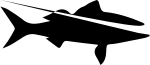

In [6]:
show(out_vec[0].tolist())

In [7]:
dataset = Dataset1D(out_vec.repeat(5,1,1))
dataset_test = Dataset1D(out_vec_test)

# dl = DataLoader(dataset, batch_size = batch_size, shuffle = True, pin_memory = True, num_workers = 1)
train_data_loader = DataLoader(dataset, batch_size = batch_size, shuffle = True)
test_data_loader = DataLoader(dataset_test, batch_size = batch_size)

In [8]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

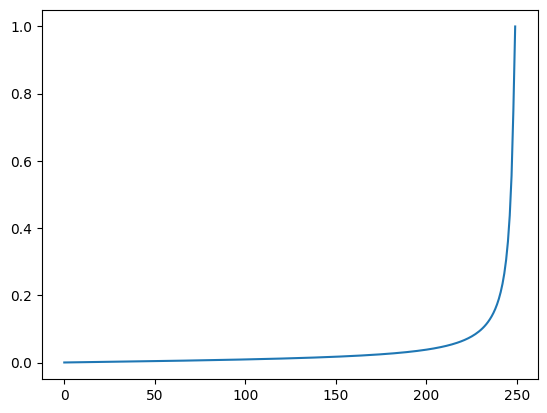

In [9]:
plt.plot(cosine_beta_schedule(timesteps=timesteps))

In [10]:


# define beta schedule
# betas = linear_beta_schedule(timesteps=timesteps)
betas = quadratic_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

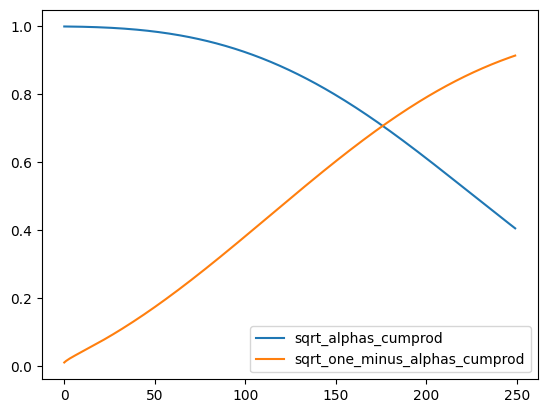

In [11]:
plt.plot(sqrt_alphas_cumprod, label="sqrt_alphas_cumprod")
plt.plot(sqrt_one_minus_alphas_cumprod, label="sqrt_one_minus_alphas_cumprod")
plt.legend()

In [12]:
# forward diffusion
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

In [13]:
def get_noisy_image(x_start, t):
    # add noise
    x_noisy = q_sample(x_start, t=t)
    return x_noisy

In [14]:
x_start = torch.tensor([[-1.,111.,4.]])

# take time step
t = torch.tensor([0, 2])

get_noisy_image(x_start, t)

tensor([[ -0.9840, 111.0174,   4.0073],
        [ -0.9708, 111.0233,   4.0130]])

In [15]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)

    predicted_noise = denoise_model(x_noisy, t)

    loss = F.mse_loss(noise, predicted_noise)


    return loss

In [16]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise

@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []

    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

In [17]:

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Denoizer(nn.Module):
    def __init__(self, d_model=11, seq_len=30, conv_size=64):
        super(Denoizer, self).__init__()
        self.d_model = d_model
        self.seq_len = seq_len
        self.conv_size = conv_size

        time_dim = conv_size*4


#         self.pos_emb = nn.Embedding(timesteps, time_dim)
        # self.dropout = nn.Dropout(0.001)

#         self.act = nn.ReLU()
        self.act = nn.SiLU()

        self.enc_init = nn.Conv1d(d_model, d_model, kernel_size=7, padding=3)

        self.enc_conv1 = nn.Conv1d(d_model, conv_size, kernel_size=3, stride=1, padding=1)
        self.enc_conv2 = nn.Conv1d(conv_size, conv_size, kernel_size=3, stride=1, padding=1)
        self.enc_pool1 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.enc_conv3 = nn.Conv1d(conv_size, conv_size*2, kernel_size=3, stride=1, padding=1)
        self.enc_conv4 = nn.Conv1d(conv_size*2, conv_size*2, kernel_size=3, stride=1, padding=1)
        self.enc_pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.enc_conv5 = nn.Conv1d(conv_size*2, conv_size*4, kernel_size=3, stride=1, padding=1)
        self.enc_conv6 = nn.Conv1d(conv_size*4, conv_size*4, kernel_size=3, stride=1, padding=1)

        self.dec_up2 = nn.ConvTranspose1d(conv_size*4, conv_size*2, kernel_size=2, stride=2, padding=0)
        self.dec_conv3 = nn.Conv1d(conv_size*4, conv_size*2, kernel_size=3, stride=1, padding=1)
        self.dec_conv4 = nn.Conv1d(conv_size*2, conv_size*2, kernel_size=3, stride=1, padding=1)

        self.dec_up3 = nn.ConvTranspose1d(conv_size*2, conv_size, kernel_size=2, stride=2, padding=0)
        self.dec_conv5 = nn.Conv1d(conv_size*2, d_model, kernel_size=3, stride=1, padding=1)
        self.dec_conv6 = nn.Conv1d(d_model, d_model, kernel_size=3, stride=1, padding=1)

        self.dec_final = nn.Conv1d(d_model, d_model, kernel_size=1)


        self.pos_emb = nn.Sequential(
            SinusoidalPositionEmbeddings(time_dim),
            nn.Linear(time_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim),
            nn.GELU(),
        )

        self.time_mlp11 = nn.Linear(time_dim, d_model)
#         self.time_mlp12 = nn.Linear(time_dim, conv_size)

        self.time_mlp21 = nn.Linear(time_dim, conv_size)
#         self.time_mlp22 = nn.Linear(time_dim, conv_size*2)

        self.time_mlp31 = nn.Linear(time_dim, conv_size*2)
#         self.time_mlp32 = nn.Linear(time_dim, conv_size*4)

        self.time_mlp41 = nn.Linear(time_dim, conv_size*4)
#         self.time_mlp42 = nn.Linear(time_dim, conv_size*2)

        self.time_mlp51 = nn.Linear(time_dim, conv_size*2)
#         self.time_mlp52 = nn.Linear(time_dim, d_model)

    def forward(self, x, t):
#         print(x.size())
        x = x.permute(0, 2, 1) # Reshape for 1D conv

        x = self.enc_init(x)

        t_emb = self.pos_emb(t)


        x = x + self.time_mlp11(t_emb).unsqueeze(-1)
        x = self.act(self.enc_conv1(x))
#         x = x + self.time_mlp12(t_emb).unsqueeze(-1)
        enc_conv1 = self.act(self.enc_conv2(x))
        x = self.enc_pool1(enc_conv1)


        x = x + self.time_mlp21(t_emb).unsqueeze(-1)
        x = self.act(self.enc_conv3(x))
#         x = x + self.time_mlp22(t_emb).unsqueeze(-1)
        enc_conv2 = self.act(self.enc_conv4(x))
        x = self.enc_pool2(enc_conv2)

        x = x + self.time_mlp31(t_emb).unsqueeze(-1)
        x = self.act(self.enc_conv5(x))
#         x = x + self.time_mlp32(t_emb).unsqueeze(-1)
        enc_conv3 = self.act(self.enc_conv6(x))

        z = self.dec_up2(enc_conv3)
        z = torch.cat([z, enc_conv2], dim=1) + self.time_mlp41(t_emb).unsqueeze(-1)
        z = self.act(self.dec_conv3(z))
#         z = z + self.time_mlp42(t_emb).unsqueeze(-1)
        z = self.act(self.dec_conv4(z))

        z = self.dec_up3(z)
        z = torch.cat([z, enc_conv1], dim=1) + self.time_mlp51(t_emb).unsqueeze(-1)
        z = self.act(self.dec_conv5(z))
#         z = z + self.time_mlp52(t_emb).unsqueeze(-1)
        z = self.act(self.dec_conv6(z))

        z = self.dec_final(z)

        z = z.permute(0, 2, 1)

        return z


In [18]:
model = Denoizer(seq_len=seq_len).to(device)


opt = torch.optim.Adam(model.parameters(), lr=0.003)
# opt = torch.optim.Adam(model.parameters(), lr=0.003, betas=(0.9, 0.99))
 
loss_fn = nn.MSELoss().to(device)

In [19]:
step = 0
metrics = {'train_loss': [], 'test_loss': []}
out_vec.size(), out_vec_test.size()

(torch.Size([12, 60, 11]), torch.Size([3, 60, 11]))

In [20]:
# from google.colab import drive
# drive.mount('/content/drive')

In [21]:
save_path = "models"

In [22]:
checkpoint = torch.load(f'{save_path}/checkpoint_epoch{195_000}.pth')
model.load_state_dict(checkpoint['model_state_dict'])
opt.load_state_dict(checkpoint['optimizer_state_dict'])
step = checkpoint['step'] + 1
metrics = {'train_loss': [], 'test_loss': []}

Step 396001, train_loss: 0.07216852903366089, test_loss: 0.27714455127716064
generate:


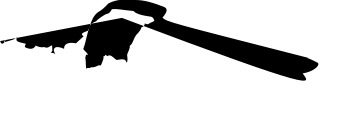

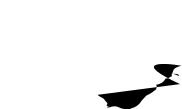

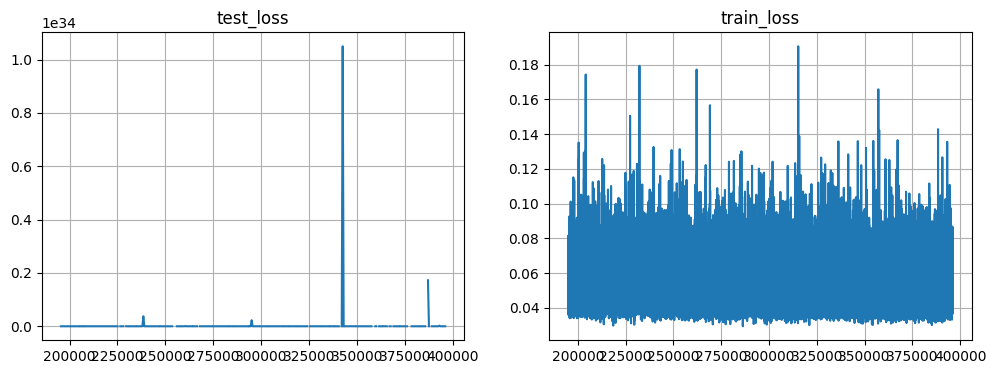

KeyboardInterrupt: 

In [23]:
# grads = None
# alpha = 0.8
# lamb = 0.1
# window_size = 2

for epoch in range(1000000):
    for x in train_data_loader:
        model.train()

        t = torch.randint(0, timesteps, (x.size(0),), device=device).long()

        loss = p_losses(model, x, t)

        opt.zero_grad()
        loss.backward()
        # grads = gradfilter_ma(model, grads=grads, window_size=window_size, lamb=lamb)

        torch.nn.utils.clip_grad_norm_(model.parameters(), 4)
        opt.step()

        metrics['train_loss'].append((step, loss.item()))

        if step%5000 == 0:
            torch.save({
              'step': step,
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': opt.state_dict(),
              'loss': loss # If you want to save the current loss
            }, f'{save_path}/checkpoint_epoch{step}.pth')

        if step%500 == 0:
            model.eval()
#             out = generate()
            sample = p_sample_loop(model, (2, 60, 11))[-1]


#             for x_test in test_data_loader:
#                 t = torch.randint(0, n_steps, (x_test.size(0), ))
#                 test_loss = p_loss(x_test, t)
#                 break

            test_loss = loss_fn(torch.tensor(sample[0]).to(device), x[0]).item()

            metrics['test_loss'].append((step, test_loss))

            try:
                clear_output()
                print(f"Step {step+1}, train_loss: {loss.item()}, test_loss: {test_loss}")

                print('generate:')
                show(sample[0].tolist())
                show(sample[1].tolist())

            except Exception as e:
                print(e)

            plt.figure(figsize=(12,4))
            for i, (name, history) in enumerate(sorted(metrics.items())):
                plt.subplot(1, len(metrics), i + 1)
                plt.title(name)
                plt.plot(*zip(*history))
                plt.grid()
            plt.show()

        step += 1

sampling loop time step: 100%|███████████████████████████████████████████████████████| 250/250 [00:03<00:00, 81.13it/s]

[ 0.2565832  -0.07409859 -0.39372927 -0.38606563 -0.45201966 -0.4179679
 -0.15931481  0.03231648 -0.06320399  0.9753565  -0.39140362]
[ 0.54768425  0.11359876  0.42360625  0.00144276  0.48963937  0.03028325
  0.8162315  -0.0136321  -0.0078098  -0.01253054 -0.6114098 ]
[ 0.3957216   0.09979939  0.46384817  0.08426707  0.4356328   0.07844557
  0.75649333 -0.00301312 -0.01139419 -0.00620764 -0.43894583]
[ 0.3983997   0.08246695  0.42310694  0.07488162  0.4134948   0.07311874
  0.753934    0.0055664  -0.00328186  0.00644828 -0.51240546]
[ 0.30757654  0.09985088  0.36965212  0.09643753  0.33441103  0.08863605
  0.75474334 -0.00329823 -0.00236825  0.0025036  -0.519074  ]
[ 0.2779804   0.11293445  0.32079265  0.11999494  0.29576942  0.11907018
  0.7549926  -0.00703878 -0.00653329  0.00645232 -0.52486897]
[ 0.26357543  0.11231109  0.28999403  0.10945506  0.2673448   0.12020031
  0.7608913  -0.00374882 -0.00180067  0.00896177 -0.5524587 ]
[ 0.23397289  0.09020216  0.2723981   0.12215396  0.2606

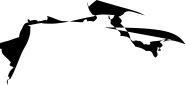

[-2.5056566e+02 -1.3933096e+02 -3.3506281e+02  2.9086426e-01
 -3.2583987e+02 -6.7579140e+01 -8.1456970e+01 -3.2475071e+01
  7.6817726e+01  1.3592618e+01 -1.5951776e+02]
[-29.323769  -32.856625  -31.247988   -9.401638  -36.525692  -19.231052
 -30.960241    1.0104384  11.56364     7.2993484   3.4080138]
[-13.006897  -23.267244  -11.305442  -12.388128  -17.890898  -14.398432
 -27.19773     5.0590787   7.6761513   6.8720565  13.193852 ]
[ 0.8401827  -0.90661716  0.94097507  1.4651039   0.26669633 -1.0161204
 -0.8156863   0.11119523 -0.8737445   0.04514303 -1.682859  ]
[ 0.258651   -0.05813334  0.24219055  0.15910918  0.2068286   0.16355647
  0.31044817  0.09676874  0.24374598  0.02656521 -0.0176252 ]
[ 0.24881214 -0.1053163   0.27213705 -0.03315432  0.25558844 -0.09228116
  0.4854226  -0.01277873 -0.01138486  0.01011353  0.04101515]
[ 0.30966288 -0.1169633   0.31649628 -0.0970259   0.3061705  -0.10076739
  0.4888521   0.00101473 -0.01099406 -0.00195041 -0.00667911]
[ 3.1835854e-01 -8.92801

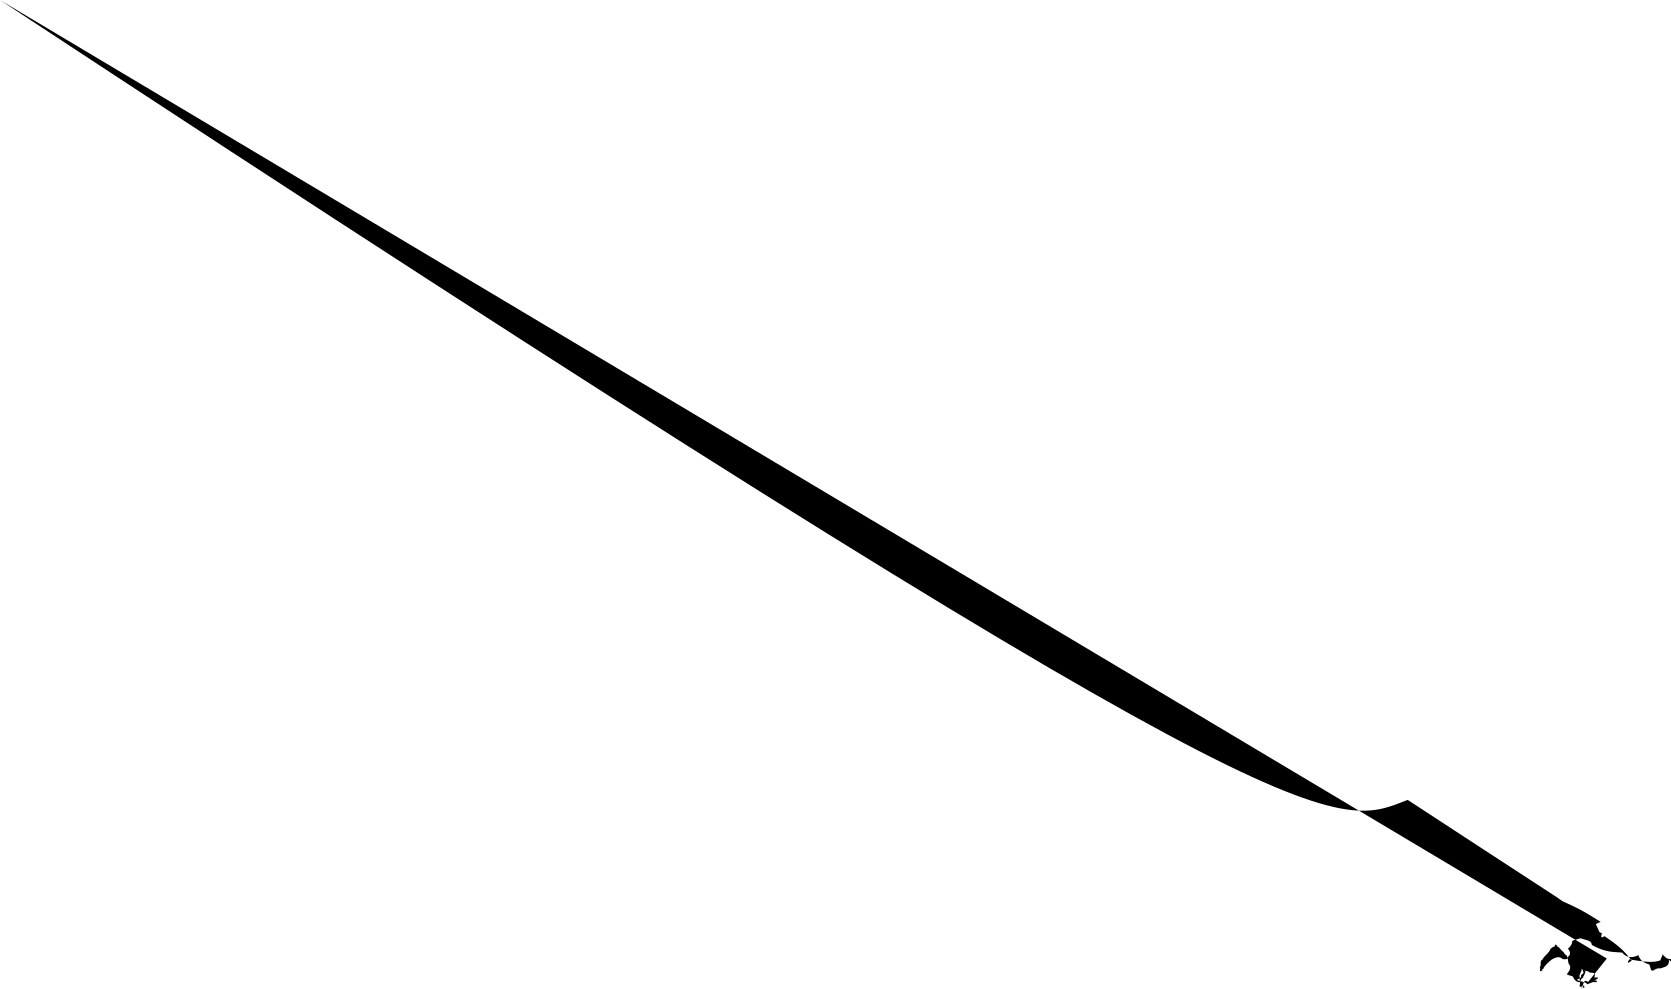

[ 0.3382157   0.23525189 -0.26496047 -0.11163265 -0.33831003 -0.09052493
 -0.23227726  0.02348145 -0.04465534  0.8893171  -0.17191294]
[ 0.7708874   0.2050294   0.5860956   0.2575534   0.7109609   0.22379582
  0.65410334 -0.00923772  0.00590357 -0.03107262 -0.27022555]
[ 0.5534544   0.2303844   0.65954757  0.21414088  0.6173232   0.2066584
  0.6022985  -0.00419735 -0.00717947 -0.00938805 -0.12609528]
[ 0.5674199   0.20892264  0.57170266  0.21419087  0.5650572   0.21635605
  0.6087023   0.01136351  0.00550848 -0.00303676 -0.19572872]
[ 0.53597003  0.18239991  0.54359317  0.18915819  0.53095937  0.19470076
  0.5933632   0.00239572 -0.00951722 -0.00589272 -0.16606514]
[ 5.5451429e-01  1.3853085e-01  5.6551570e-01  1.7601664e-01
  5.6672245e-01  1.5249592e-01  5.7841223e-01  2.0617514e-03
  4.8846932e-04 -5.5930652e-03 -1.2599452e-01]
[ 0.5274801   0.08085245  0.5596864   0.12515785  0.5625152   0.09051966
  0.57674617  0.01396429 -0.00692721 -0.0117133  -0.10977291]
[ 4.3926594e-01  9.233

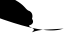

[-3721.4814 -1392.1936 -1880.131   2683.3008 -3840.1477  1752.7814
 -2325.6663   641.7599  4652.2666  -557.0118 -1154.5941]
[-253538.83   -140066.     -341941.34     -1130.6749 -332373.62
  -69052.86    -83322.94    -31631.193    79094.99     17266.307
 -163460.66  ]
[-2517.6401   2446.3826   4674.117     451.20605 -1161.9836   2878.2332
 -6163.895    -104.27749  6401.96     -527.46094  -394.57562]
[-475478.2    -262033.25   -640151.7       -820.2592 -622380.75
 -129579.38   -156682.19    -60758.883   148101.67     30170.826
 -305663.16  ]
[-1210.0126  -1163.9701   3686.553   -1347.4481   -572.59503 -2099.6536
 -6773.517    1975.9526   2294.491     -42.48552  1199.9369 ]
[-392327.16   -214261.1    -530251.25     -6258.1743 -519512.94
 -106119.23   -131289.17    -46837.906   124806.81     28553.49
 -255652.44  ]
[-15582.327  -15493.095  -20095.646    5459.6147 -25998.498  -10608.701
 -12388.092   -1464.9752   1468.2456   2452.5667 -16808.105 ]
[-2209.9814 -4703.7383  2239.7336 -2388.083

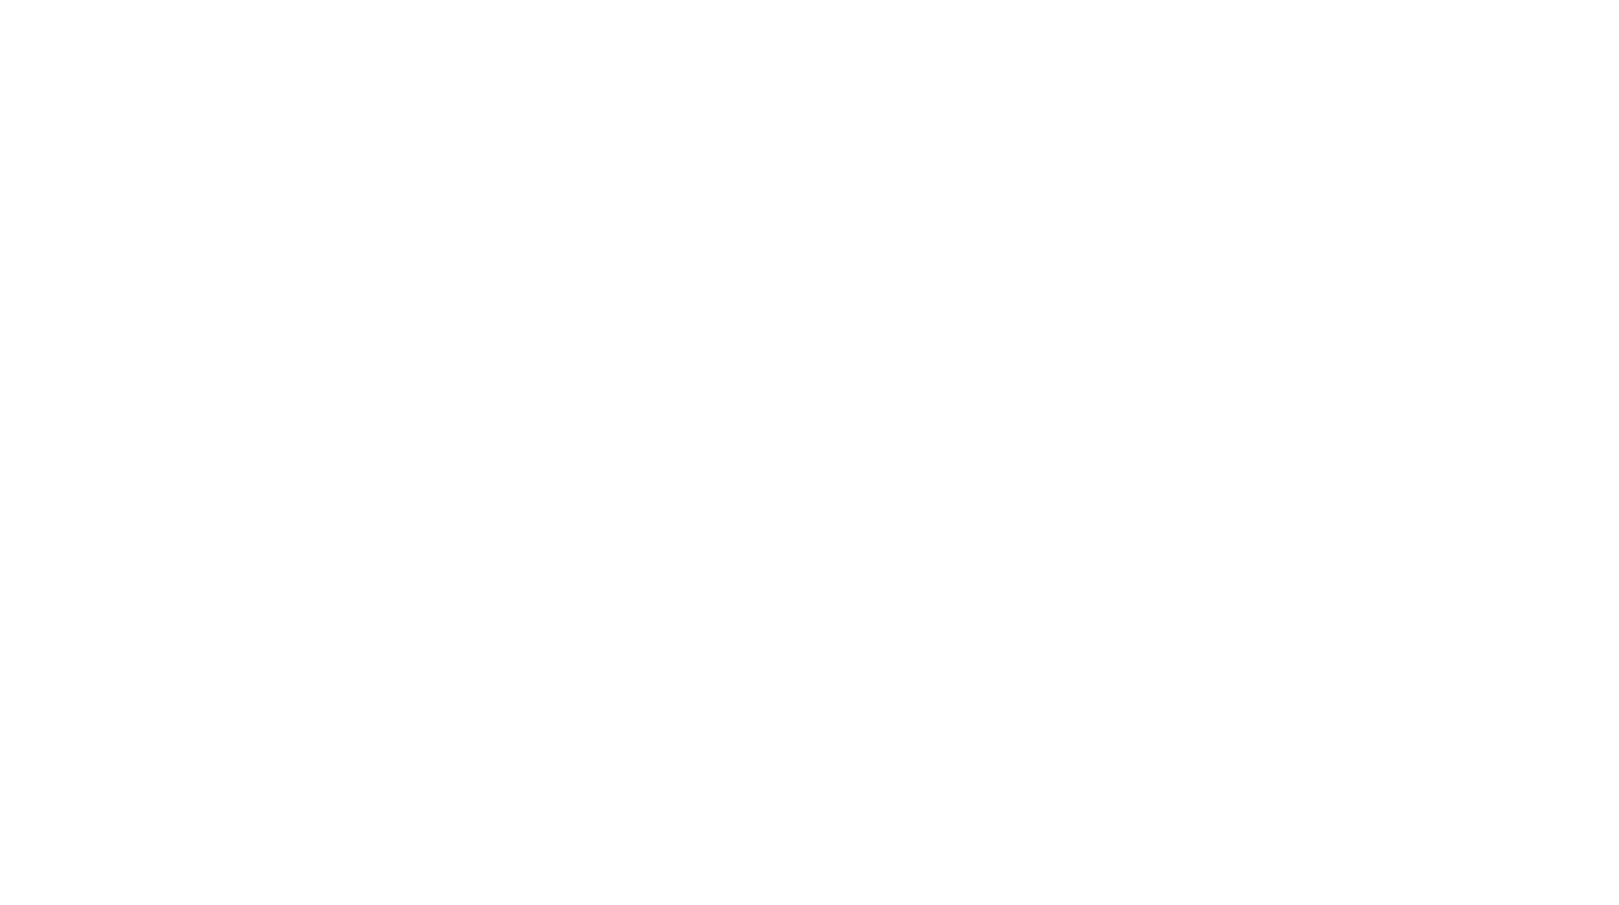

[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[-225.2841    -123.36881   -302.85754     -1.9241648 -295.17896
  -61.94555    -

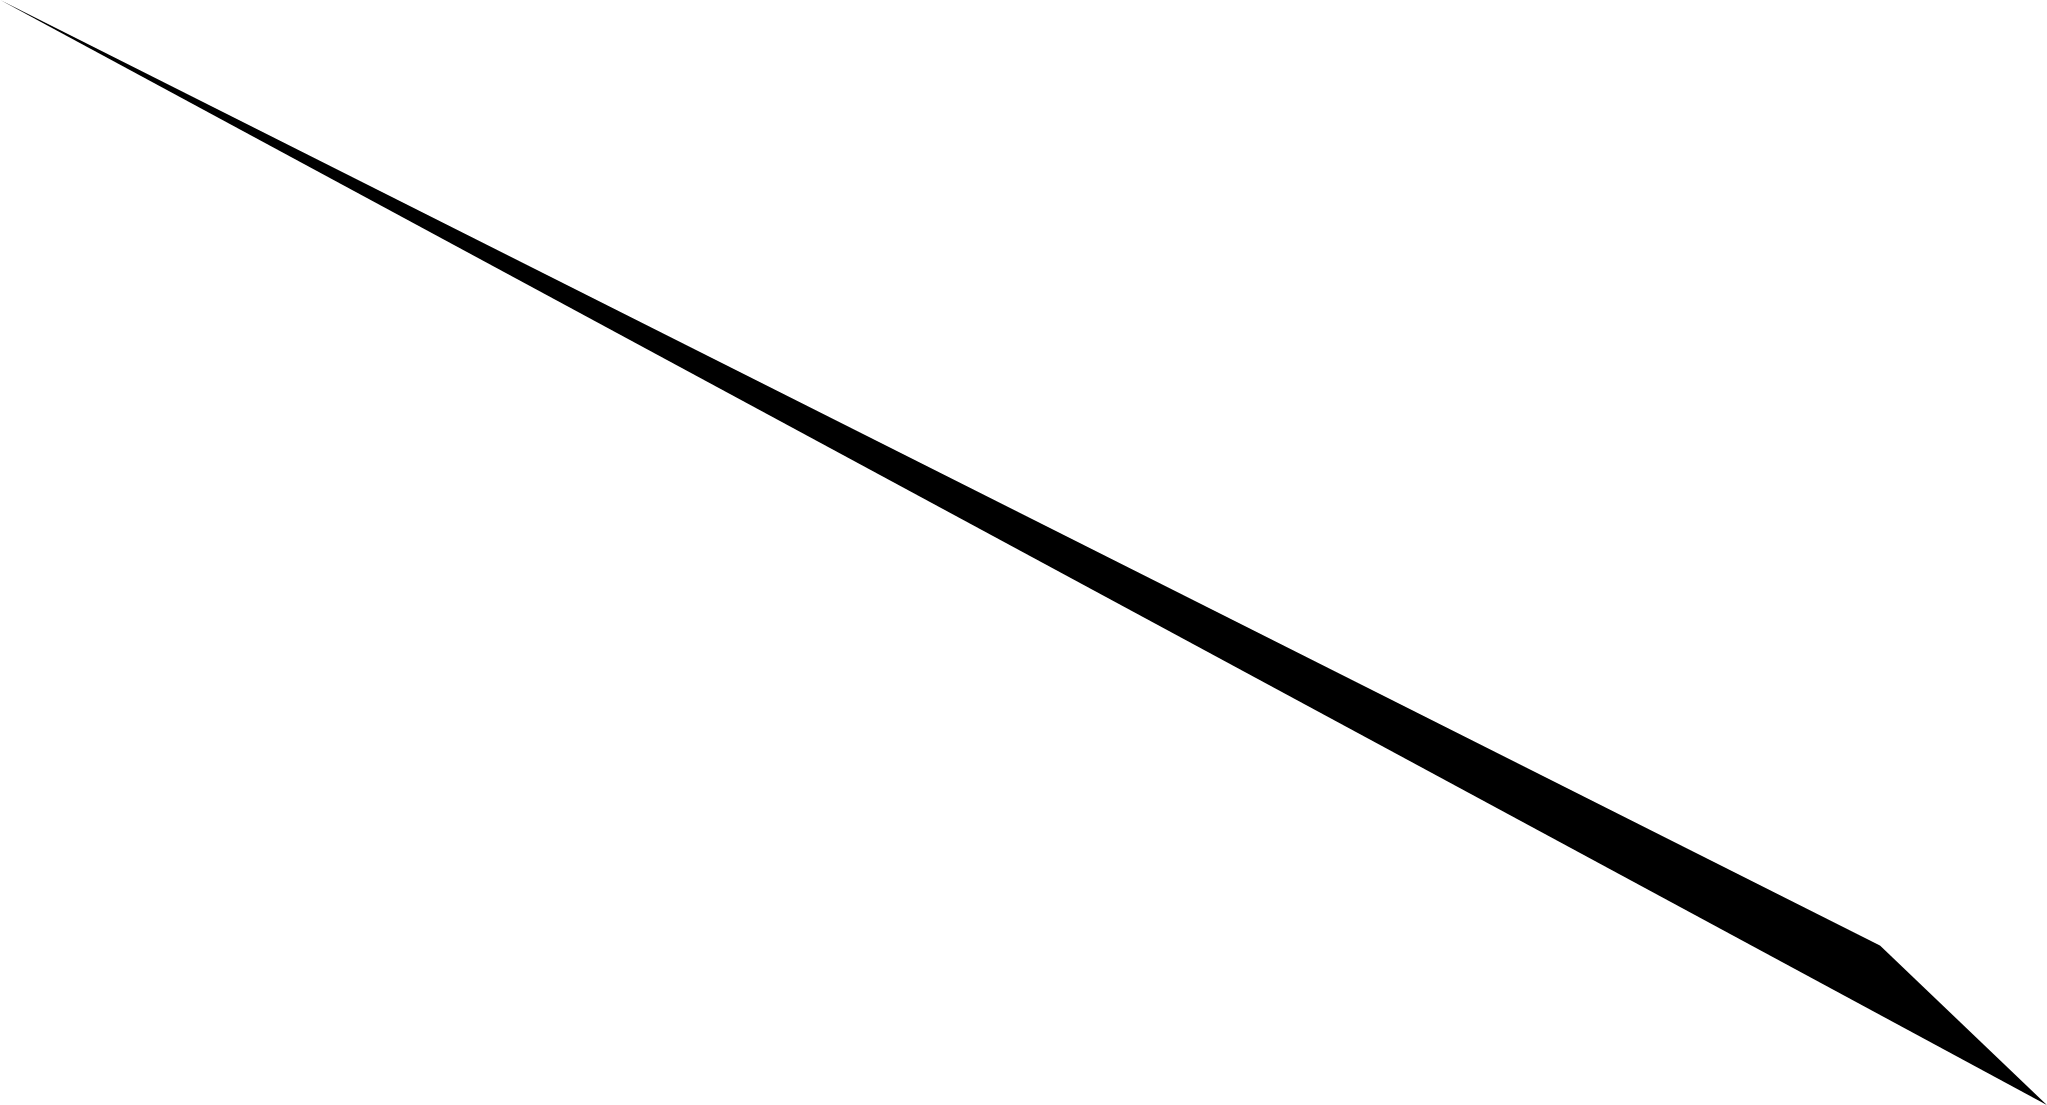

[-0.4434082   0.02147066 -0.3824303  -0.17360093 -0.46988872 -0.20330745
 -0.1430975   0.03489546 -0.02182363  0.8268962  -0.22333714]
[-0.02362744  0.09599902 -0.25205767  0.0147596  -0.08430728  0.05652781
  0.66162205 -0.01454797 -0.02910687 -0.01021444 -0.3148658 ]
[-0.00470367  0.0983808  -0.02687022  0.07845625 -0.01625334  0.08714299
  0.56308573  0.00476906  0.00117829  0.00514601 -0.08406613]
[ 0.01866287  0.06726109  0.01400591  0.05064872  0.00587885  0.11019599
  0.52644295 -0.00770998 -0.00786145 -0.00331915 -0.12115814]
[ 0.0017138   0.0301405  -0.40694848 -0.130726   -0.44705206 -0.13015804
 -0.5031501  -0.00548851  1.0222543   0.02571396 -0.05090053]
[-0.04341038  0.00340414 -0.03674001  0.05232514 -0.0231721   0.08560172
  0.50645196 -0.00876191 -0.01245882  0.0124519  -0.01202125]
[-0.08134539  0.0204659  -0.05539836  0.02299573 -0.06242445  0.02662822
  0.5030927  -0.00149754 -0.01285383  0.0064373   0.01553086]
[-0.16281363  0.03753659 -0.12226248  0.02408645 -0.113

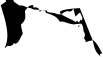

[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[-1.0118371  -0.48521638 -0.6037637  -0.47358823 -0.73404956 -0.51726335
 -0.21488868  0.04976829 -0.05808807  0.9181797  -0.20659152]
[-0.40067583 -0.15667553 -0.6640167  -0.31868437 -0.5219862  -0.26316047
  0.68147665 -0.02825332  0.00628968 -0.01305778 -0.3826197 ]
[-0.3982399  -0.16388778 -0.44435465 -0.17331833 -0.41759852 -0.17979869
  0.589928    0.0079628  -0.00272235 -0.01426701 -0.14698668]
[-0.36046302 -0.10990882 -0.35893106 -0.15680933 -0.35196    -0.13121505
  0.56762654 -0.0023018  -0.00611792 -0.00077161 -0.14539996]


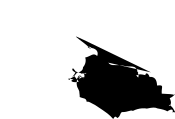

[-1.8384247   0.48042983 -1.3173397   0.4946929  -1.4938923   0.5419241
 -1.5140611   0.03650298  1.0068896   0.67811257  1.0936384 ]
[-0.98090327  0.05547106 -1.0484926   0.57988554 -0.95148     0.3021744
 -0.17050299 -0.07024505  0.28260228 -0.06589402  0.70386714]
[-0.7151378   0.01504903 -0.9398212   0.12339877 -0.8570126   0.09446269
  0.12396558 -0.01876317  0.04560447  0.02807181  0.5835693 ]
[-0.33101216 -0.13914937 -0.5741998  -0.05044161 -0.48098543 -0.09288038
  0.17530525  0.00273084  0.02176893 -0.00402223  0.6147954 ]
[-0.20300817 -0.1943136  -0.29139668 -0.15220854 -0.24107149 -0.15832657
  0.1650569   0.01264674  0.00533386  0.00950523  0.63525295]
[-0.20212637 -0.15326083 -0.19685717 -0.15787598 -0.19435045 -0.14488564
  0.19119334 -0.00209813  0.00926031 -0.00830972  0.6058338 ]
[-0.2324793  -0.1344998  -0.20852453 -0.14250427 -0.22351573 -0.12705468
  0.20873262  0.00376401 -0.00662725  0.00455363  0.5803254 ]
[-0.23580264 -0.12615572 -0.2057923  -0.11914202 -0.22611

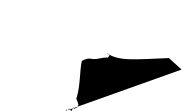

[-3.4763541 -2.183175  -4.7971153 -0.5221579 -4.8667893 -1.3589278
 -1.2706714 -0.3626336  0.913643   1.002152  -2.1619103]
[ 0.13549471 -1.2614993   0.21504313 -0.64726907  0.0424136  -0.7850202
 -0.6191594   0.25604457  0.2540025   0.26185873  0.67593133]
[ 0.33532414 -0.0728001   0.38770115 -0.06934435  0.3396759  -0.07474232
  0.6090457   0.01813245 -0.03042579 -0.01160205 -0.27692655]
[ 4.2763197e-01  4.6367034e-02  4.1183037e-01 -1.7784004e-03
  4.2629886e-01  1.3615652e-02  7.0514500e-01 -4.5669777e-04
 -4.9917125e-03 -4.5858752e-03 -4.2890427e-01]
[ 0.33801445  0.05414001  0.3930175   0.04188088  0.36678818  0.04986276
  0.69813555  0.00814029  0.00295603 -0.0020242  -0.41586393]
[ 0.36242265  0.09420118  0.36195064  0.11079677  0.34223536  0.09266104
  0.64414674 -0.00562674  0.02474325 -0.00895261 -0.29170054]
[ 0.5190363   0.06129699  0.388786    0.12168708  0.36052752  0.1343383
  0.5442697   0.02204001  0.12277201  0.08944445 -0.4675315 ]
[ 1.0861045   0.21926609  0.836947

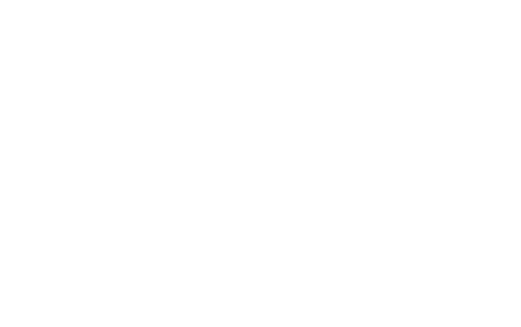

[-0.6884988   0.04749909 -0.3278511  -0.11175638 -0.38037854 -0.14159738
 -0.19932403  0.03799823 -0.00620416  0.94497114 -0.3581889 ]
[-0.31582394  0.22012456 -0.4780949   0.05733534 -0.4076367   0.12311351
  0.71614057 -0.02263521  0.00425783  0.01439061 -0.49212864]
[-3.2562196e-01  2.0310187e-01 -3.5980999e-01  2.0819661e-01
 -3.5347232e-01  2.0900884e-01  6.6544151e-01  4.9665908e-04
  2.3994256e-02 -5.2866074e-03 -2.9327789e-01]
[-0.24699304  0.24922028 -0.29425374  0.21205881 -0.27118313  0.24223687
  0.6154106  -0.00262379 -0.00368631  0.00696327 -0.23258796]
[-0.27487656  0.23376207 -0.24977414  0.22785388 -0.2601924   0.24487202
  0.588653    0.01169578 -0.00901612  0.01404982 -0.16274415]
[-0.317433    0.24089164 -0.2827691   0.23675227 -0.30103764  0.2461542
  0.5403238   0.00287762 -0.00270536 -0.0046884  -0.08673439]
[-3.8863423e-01  2.0541765e-01 -3.4860957e-01  2.2419962e-01
 -3.6143604e-01  2.1158822e-01  4.6771619e-01  1.8670886e-03
  1.9922544e-04 -5.9578898e-03  5.1

[-2.6587831e+11 -1.5227373e+11 -3.5389650e+11  8.3026355e+09
 -3.4332892e+11 -6.6682024e+10 -8.5056758e+10 -3.1031863e+10
  8.6186615e+10  1.2613903e+10 -1.6605916e+11]
[-1.00756095e+11 -7.93548308e+10 -1.22667557e+11 -4.23962445e+09
 -1.30651652e+11 -3.45129861e+10 -5.37856532e+10 -8.16511693e+09
  3.46160538e+10  9.89342310e+09 -4.19931955e+10]
[-5.2777421e+08 -7.0527132e+10  2.4735386e+10 -3.7995512e+10
  3.5905943e+09 -4.0688075e+10 -9.3598556e+10  2.2138085e+10
  2.0961501e+10  1.3921892e+10  8.9440649e+10]
[-1.3271671e+11 -8.1136239e+10 -1.8674079e+11 -3.1030202e+10
 -1.9958347e+11 -4.0657715e+10 -6.5249632e+10  3.2973885e+09
  5.2897415e+10  2.9437043e+10 -8.4424040e+10]
[-4.2243761e+09  5.5084104e+09  6.1423800e+09  4.3139758e+09
 -1.2517628e+08  3.8207352e+09 -9.5710597e+09  1.4030792e+09
  1.0000571e+10 -2.6455703e+09 -3.0735872e+09]
[-7.87252773e+11 -4.32153559e+11 -1.05889694e+12  2.45848336e+08
 -1.03060858e+12 -2.13565784e+11 -2.62124995e+11 -9.94369044e+10
  2.48157553e+

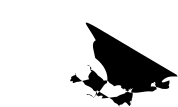

[-1.1289179   0.04635393 -0.6638895  -0.05400686 -0.7477654  -0.03794877
 -0.20207094  0.03403782 -0.04588829  0.8675997  -0.09741879]
[-0.48263642  0.04846175 -0.67961824 -0.00404456 -0.5374024  -0.00734803
  0.5973179  -0.02011327  0.00930415  0.01467999 -0.2954607 ]
[-4.5123965e-01 -3.5848983e-03 -5.0551659e-01  7.4174754e-02
 -4.9267617e-01  3.1873293e-02  5.9983593e-01  3.3272323e-04
  1.7471373e-02 -2.1474257e-02 -2.0324777e-01]
[-0.20068753 -0.03749377 -0.35825747 -0.01053886 -0.2934354  -0.01787359
  0.5626088  -0.00375765 -0.01210159 -0.0020047  -0.16210198]
[-0.30478913 -0.04131079 -0.23565137 -0.05208939 -0.27577692 -0.03791311
  0.55529934  0.00943896  0.00153198  0.01191356 -0.12806681]
[-0.2906455   0.01878293 -0.2942451  -0.01262304 -0.29403403  0.01420796
  0.53805906 -0.00270807 -0.01387876 -0.00697362 -0.08145597]
[-0.34874332  0.0718173  -0.2994935   0.03825815 -0.317988    0.04706945
  0.5428929   0.01378599 -0.00851346 -0.01740327 -0.06702201]
[-0.40807658  0.09948

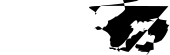

[-29.374382   -15.690194   -38.223587    -0.21558987 -37.356743
  -7.7381907   -9.482887    -3.583899     8.592928     2.2427604
 -17.580437  ]
[-3.00802    -3.125195   -3.5660558  -0.75519013 -4.0474596  -1.7813607
 -2.37707    -0.01391     0.8791701   0.5894969   0.02934671]
[-0.37366194 -0.81259435 -0.15962696 -0.3858516  -0.4409745  -0.535963
 -0.6982911   0.29636577  0.11511622  0.20329592  1.1980284 ]
[-0.28699362  0.04946103 -0.29679537  0.0130168  -0.28757733  0.02543943
  0.4596076   0.00566692  0.00438948  0.00459804  0.01849724]
[-0.37584072  0.08875689 -0.32922843  0.06038952 -0.34206092  0.07016645
  0.47008088  0.01131092 -0.00509992  0.00602385  0.06594574]
[-0.36609393  0.13227215 -0.37265456  0.08905257 -0.35846236  0.09924519
  0.45551854 -0.00299432 -0.00370244 -0.01064996  0.10412252]
[-0.35528448  0.12769295 -0.35664535  0.1425073  -0.35740265  0.12572387
  0.43623728 -0.01129295  0.00307216 -0.00117707  0.09011955]
[-0.3910369   0.08866955 -0.3623209   0.12975006 

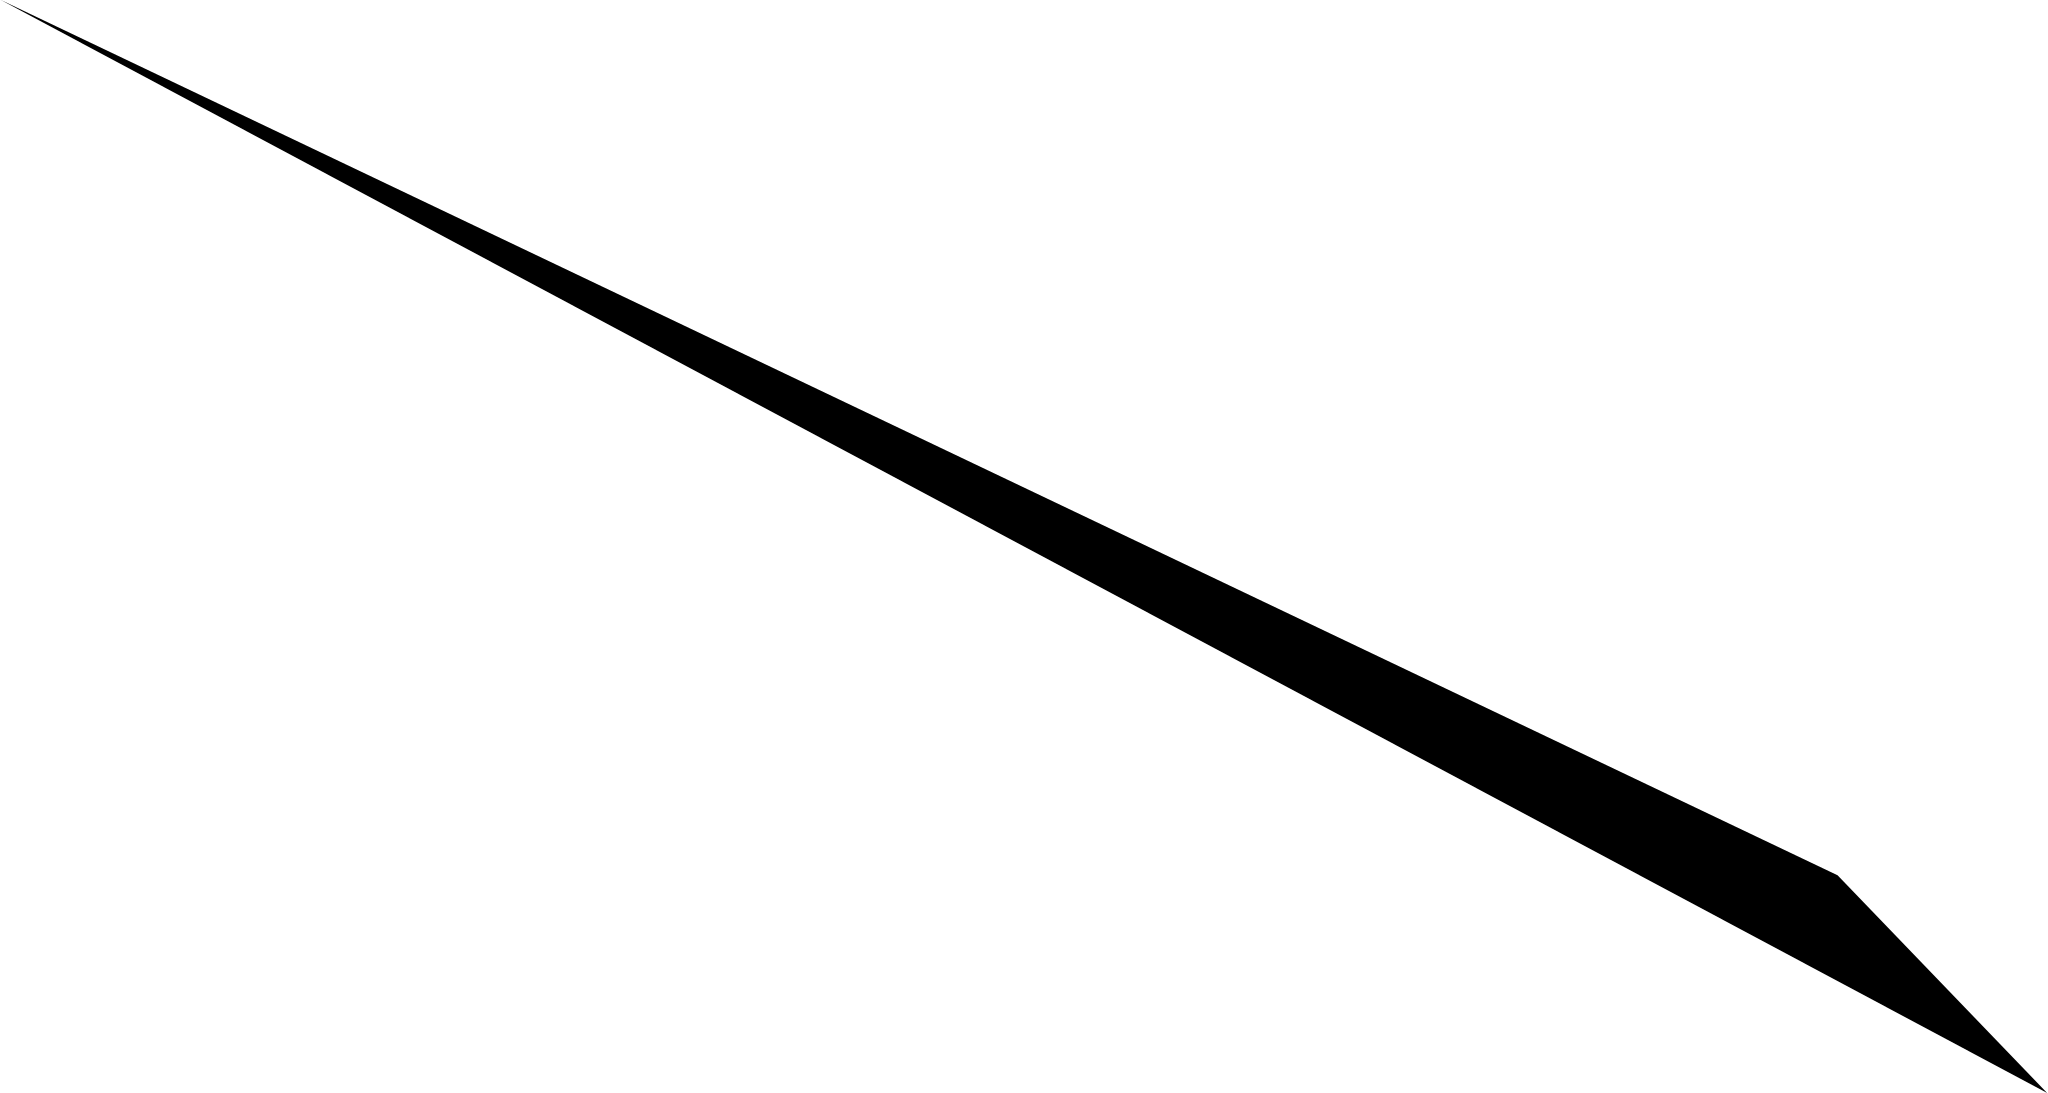

[ 0.31624123  0.02230513 -0.2713796  -0.24738999 -0.3109796  -0.26548964
 -0.16237825  0.02068776 -0.04172306  0.9796432  -0.5181316 ]
[ 0.42218807  0.06945574  0.42068824  0.08145263  0.4207483   0.06664303
  0.8385698  -0.01853237  0.00205532 -0.0195422  -0.6497502 ]
[ 0.3413456  -0.05698984  0.39210436  0.03777725  0.35743433 -0.02374221
  0.77630836 -0.00265417  0.00490053 -0.015681   -0.506075  ]
[ 0.3416091  -0.08840819  0.3696575  -0.05744595  0.35513744 -0.07487967
  0.7627621  -0.00568525  0.01089684 -0.01541433 -0.54200864]
[ 0.27307308  0.06513597  0.33206695 -0.03269439  0.30657208  0.01510504
  0.76755327 -0.00615745 -0.00948088 -0.006092   -0.51768535]
[ 2.6326245e-01  6.0003053e-02  2.7098837e-01  8.3390325e-02
  2.7445117e-01  7.6451570e-02  7.4553025e-01 -2.1521570e-03
 -9.8430561e-03  6.2880898e-04 -5.1283777e-01]
[ 2.6771396e-01  3.5793137e-02  2.6458430e-01  4.8284996e-02
  2.7170315e-01  4.5910515e-02  7.4210364e-01  6.4101685e-03
 -1.0894309e-02 -1.4699869e-04 -4.

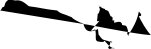

[-147.58345  -400.23502   156.68149    21.949913 -400.36017   547.9052
 -123.11215   271.26608   674.06573  -508.6508   -122.40912 ]
[ -767.25385 -1276.8976   1178.4767    151.05998   413.74704  1359.7
  -477.39545   330.61908  1504.0778   1751.072   -1043.9119 ]
[  359.87393  -539.4238   1870.3699   -247.10649 -1224.0359   1642.1385
 -1359.9897   1525.8545   1550.4927    156.2263  -1395.9583 ]
[  162.52742 -2761.5806   1438.2549  -1007.35364  -160.95969   884.4543
  -393.1851   1026.163    1716.3623   1067.8279   -263.86432]
[ -88.25149 -838.8742  1853.7421   504.32413 -910.1107   990.2727
 -673.09564  -69.86999 1092.0916  1460.2214  -967.7933 ]
[ -142.63127 -1451.5667    876.4346   -143.67865   -54.88837  1815.8657
   183.29745  1608.1814   2329.9336    573.9237   -497.86328]
[  -78.2765  -1344.5408   3078.2466    320.0051  -1212.358    1807.8916
 -1808.3315    811.08954  1796.2426   1434.6495  -2317.19   ]
[  174.06497 -5401.456    2998.5483  -2418.324    -386.23093 -1069.4739
 -370

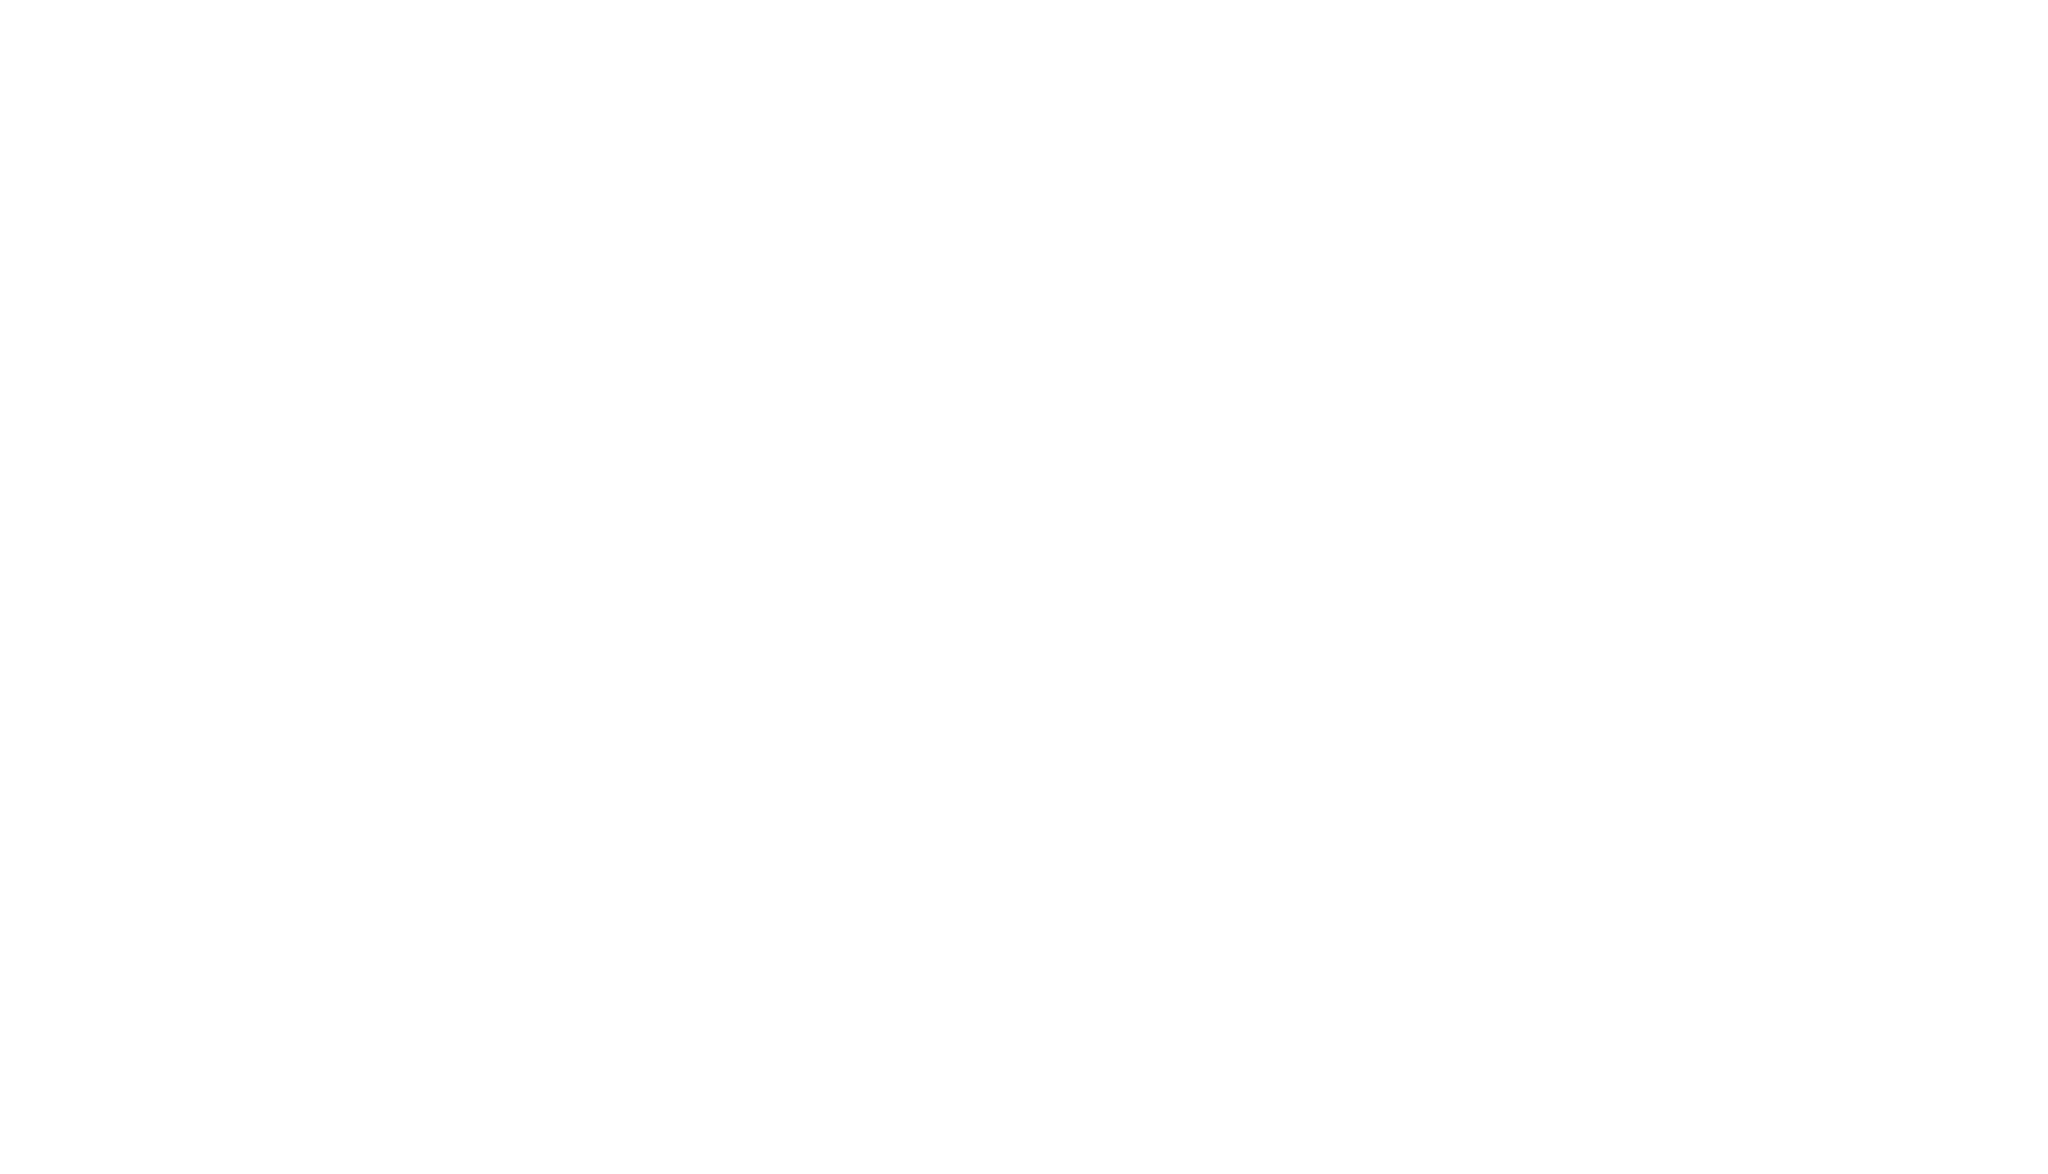

[-2.0534690e+32  3.7461683e+32  2.6111061e+33 -5.3067867e+32
 -1.7639163e+33  3.5033935e+33 -1.9558733e+33  1.7288625e+33
  4.6832739e+33 -1.4881469e+33 -7.7348590e+32]
[-7.7714008e+34 -4.9424721e+34 -9.7042872e+34  2.7741472e+33
 -9.8747397e+34 -1.4197265e+34 -2.5554611e+34 -7.7059273e+33
  2.8745153e+34  9.3023141e+33 -5.1505184e+34]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[-1.9079112  -3.2210946   0.32607597 -0.90245533 -1.3432876  -1.2101935
 -7.833005    1.3434162   2.7601433   1.6561532   7.3926687 ]
[-23.54174   -12.526555  -32.007603   -1.1244684 -32.288467   -5.514634
  -9.203657   -1.5370696   8.26028     2.8628526 -13.878458 ]
[-0.5517289  -0.64096165 -

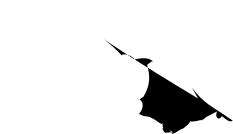

[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[ 0.0894865   0.49415526  0.06029916  0.09376144  0.16282117  0.06138954
  0.01598932 -0.01720768 -0.00816859  1.0286113  -1.0960443 ]
[-0.01935513  0.3694576   0.01924101  0.4033286   0.04938366  0.39911982
  0.9701855   0.01459771 -0.00488335 -0.00671385 -0.99824256]
[ 0.02026697  0.15670724  0.01042257  0.3008434   0.01089549  0.24264966
  0.9599305   0.00378012  0.00137865  0.01023022 -0.92299974]
[-0.00431633  0.10063204  0.02053302  0.13800155  0.02577986  0.14870027
  0.91771495  0.00487647  0.01726013 -0.00579798 -0.81946474]


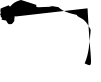

[-144.91272 -569.4755   476.75696  152.17374 -604.4543  1152.5424
 -298.31738  581.21014 1301.1278  -882.0461  -107.13209]
[-1377.9825  -2488.5474   2186.2488     94.07011   820.04456  2944.112
  -886.80554   967.14465  3047.753    3253.2578  -2008.6299 ]
[ 1480.6864  -2125.259    4006.3328   -411.52536 -2686.819    3400.2334
 -2692.3596   2937.1316   3093.13      468.65106 -3397.8994 ]
[ -383.57352 -6338.0728   3787.8074  -1531.3397   -202.62625   105.86606
 -1764.1953   1462.2589   2885.889    4047.121     444.64227]
[  -17.972246  -532.33215   2572.0564     550.5762   -1694.378
  1589.0602   -1224.0922     409.40228   1763.2056     702.6236
 -1057.0995  ]
[ -344.50818  -2311.646     1531.1621    -147.74522    -17.640417
  2353.3103     345.5607    2012.9272    3204.613     1385.5543
  -966.37897 ]
[   48.193966 -1681.3065    4126.486      425.33765  -1627.0281
  2410.9092   -2759.373     1322.7651    2408.444     1771.2494
 -3342.176   ]
[  455.2764 -9327.2295  4776.175  -4765.039  

[-372.274     -203.78056   -501.22794     -3.9797235 -489.12167
 -101.89281   -122.8213     -45.49225    116.542015    26.725811
 -240.06972  ]
[-22.286434  -17.485374  -29.328945    3.0097442 -32.802044  -10.936751
 -11.825007   -2.635089    4.541016    2.9792273 -18.087336 ]
[ -3.0980284  -31.05687     10.590143   -15.429594     0.41849983
 -19.01427    -40.11131      9.01557      6.8396854    7.1007786
  39.70169   ]
[-0.13754304 -0.8049813  -0.11402342  0.5798675   0.65861714  2.4432733
 -0.89024246  0.56699425  1.8600557  -0.17029849 -0.19289695]
[ 1.0303786 -2.4036136  3.170742   1.6056546 -1.9910574  4.1228204
 -4.7041945  1.2780228  5.1155105  4.7463536 -3.5809493]
[ 0.20017669 -4.586965    3.7956896  -2.1987684  -1.8364301   6.5243964
  0.5155746   4.9601903   7.312985   -0.18161719 -2.0510242 ]
[ 0.1695896 -5.2947397  6.844596   1.5895245 -2.2114127  4.6868796
 -2.9474702  1.8191353  4.22003    7.1239176 -5.702104 ]
[ 1.5403572 -3.9269972  3.2545955 -2.4263372 -1.9194217  4.8

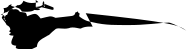

[-1.0931239  -0.41259098 -0.6505302  -0.43771198 -0.7916347  -0.4876353
 -0.16699597  0.04172884 -0.06288942  0.836535   -0.13712046]
[-0.46009713 -0.02909805 -0.7177931  -0.25409505 -0.5543632  -0.18376692
  0.67258304 -0.02906968  0.00371404 -0.02568422 -0.3542853 ]
[-0.41479677  0.00994314 -0.4945957  -0.03871887 -0.43292424 -0.0351215
  0.6028333   0.00499657  0.01090158 -0.02749445 -0.16334887]
[-0.29858243  0.05580798 -0.351428    0.01145161 -0.33368477  0.03657857
  0.57661235 -0.00122347  0.00150345 -0.00539204 -0.19378448]
[-3.2646525e-01  1.0031184e-01 -3.2479867e-01  7.4533284e-02
 -3.3585393e-01  8.4075607e-02  5.8228564e-01  5.0060870e-04
  4.6852510e-03  8.6355144e-03 -2.1158856e-01]
[-0.29845482  0.17741787 -0.32060078  0.13667215 -0.31614196  0.15229869
  0.6057224  -0.00577759 -0.01648324  0.00965651 -0.25039834]
[-0.2392233   0.2110345  -0.2563834   0.18888514 -0.26244566  0.18917248
  0.6477019   0.00327725 -0.00671167  0.00414453 -0.29546463]
[-0.22092736  0.2131839

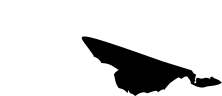

[-1.2653058  -0.49776226 -0.72315    -0.3645517  -0.87548864 -0.42807838
 -0.22780341  0.06000149 -0.0571192   0.87579036 -0.11741786]
[-0.62847435 -0.14258924 -0.8394086  -0.36208692 -0.69253635 -0.2930314
  0.6421595  -0.02296074 -0.00089267  0.01341511 -0.32793838]
[-0.6372776   0.13332896 -0.6443054  -0.10087096 -0.61241424 -0.01884705
  0.59031826  0.00272714 -0.01152957 -0.01949995 -0.12266137]
[-0.54191005  0.08767673 -0.5868933   0.04049798 -0.5588722   0.07080655
  0.56857073 -0.00137363 -0.01832624 -0.01023933 -0.13391905]
[-0.58354634  0.06966048 -0.55850047  0.04306285 -0.5589429   0.06559175
  0.5501374   0.00364833  0.00240826  0.00175026 -0.10929088]
[-0.6099539   0.10502563 -0.59522396  0.0673025  -0.59655046  0.08200607
  0.5417806   0.00848593 -0.00424811 -0.00365471 -0.06587128]
[-0.628062    0.14207663 -0.62843066  0.10425674 -0.6199996   0.12759255
  0.5287221   0.00443674 -0.00621759  0.00446932 -0.05998028]
[-0.5833382   0.17561488 -0.62207353  0.15617877 -0.6066

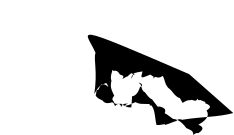

[ 0.4855715  -0.14439777 -0.25127777 -0.29864052 -0.31257784 -0.3162126
 -0.1437841   0.0245033  -0.05556367  0.99016845 -0.54787207]
[ 0.70226914  0.00615716 -0.13331366 -0.126055   -0.14190583 -0.10514099
 -0.17594647 -0.01745313  1.0091374  -0.0050393  -0.6761884 ]
[ 0.57902545 -0.0381964   0.59582335  0.02058098  0.61871976  0.02967735
  0.7795771  -0.00362877 -0.02895829  0.00523303 -0.52330637]
[ 0.58984643 -0.00220016  0.6191717  -0.02059454  0.59843814 -0.00612054
  0.7545567   0.00201031 -0.00692861 -0.00348329 -0.5262822 ]
[ 0.57047313  0.01933824  0.5808155   0.01108959  0.5787109   0.04837098
  0.7240889   0.01046221 -0.0032497  -0.00120166 -0.4706048 ]
[ 0.5604244   0.0576287   0.590255    0.05562839  0.5831504   0.06730255
  0.70190096  0.0163     -0.00771814 -0.00282997 -0.446886  ]
[ 0.5242441   0.06577995  0.5601014   0.06216502  0.56561834  0.07236236
  0.6842272   0.00533609 -0.00319682  0.00261664 -0.37094045]
[ 0.49263054  0.05261186  0.50813293  0.06435858  0.5285

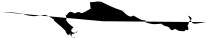

[-243.78061    -134.9413     -322.88684      -0.64935076 -315.4824
  -65.55169     -78.513       -30.557514     75.38787      14.300106
 -154.75557   ]
[-9.220093   -9.469448   -7.635067   -0.92596555 -9.848544   -1.9478822
 -3.2238863  -0.91917676  1.9297346   1.8382688  -8.754438  ]
[ 0.8558373 -4.2581406  5.890156   1.7320082 -1.7160689  5.241919
 -5.6141677  2.0795224  5.0251083  6.935623  -7.100321 ]
[ 0.18341626 -5.582939    3.5753071  -2.534656   -1.8283608   9.562171
 -0.31676152  6.509243    9.313911   -2.188857   -2.229728  ]
[ 0.20727299 -7.412132   10.0756      3.6396883  -3.2634532   7.3130994
 -5.850981    1.7265387   7.4261923  12.120747   -8.967804  ]
[ 1.3954407 -7.489585   5.522556  -4.5035753 -3.3630562 10.714095
  0.506268   8.071906  12.895427  -0.9941127 -3.990447 ]
[ -0.6475472  -9.910761   12.561321    2.683588   -4.428305    7.952258
  -5.9593215   3.3998327   8.68776    12.76363   -10.525834 ]
[ 2.081619  -6.3794317  5.699864  -3.5074048 -3.3273978  8.084732
 

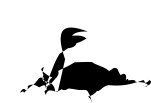

[-0.9758382  -0.5858611  -0.662798   -0.57600594 -0.8273433  -0.6372519
 -0.18264438  0.06964865 -0.08453099  0.901551   -0.18412168]
[-0.33778945 -0.20039803 -0.6361008  -0.42411396 -0.4948675  -0.3677715
  0.656383   -0.03260814  0.00921779 -0.00361163 -0.36100888]
[-0.3923516  -0.06413638 -0.39046523 -0.17696483 -0.36769244 -0.14001088
  0.5557119   0.00560835  0.00426599 -0.00655004 -0.10636376]
[-0.29394    -0.04710726 -0.3147068  -0.07156223 -0.31137496 -0.05253074
  0.58563256  0.00096709 -0.02391256  0.01083672 -0.17030512]
[-0.34625846 -0.05216632 -0.3311853  -0.07087708 -0.34317327 -0.04418771
  0.5657281   0.00701684 -0.02032367  0.01477553 -0.13193782]
[-0.40404212 -0.07075682 -0.4328016  -0.30772632 -0.4863135  -0.30592772
 -0.42853835 -0.00897803  0.9784456   0.01582201 -0.10633741]
[-4.4160709e-01 -4.3354090e-02 -4.4418180e-01 -3.4440294e-02
 -4.2964870e-01 -2.4178840e-02  5.2931017e-01  4.9865257e-04
 -6.4272149e-03  1.1117125e-02 -8.6938806e-02]
[-0.4479252  -0.0223534

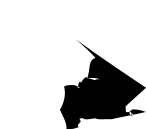

[ 1.4204798   0.530822    0.25191763  0.3349383   0.29042423  0.35075337
  0.11840047 -0.00403782  0.03638029  1.0002009  -1.3371832 ]
[ 1.1191632   0.36076722  1.2954257   0.445042    1.1968853   0.40505865
  1.1282928   0.01086049  0.0269207  -0.02391554 -1.2217926 ]
[ 1.1255267   0.2954461   1.1804042   0.3564287   1.1403271   0.31359944
  1.1269411   0.00173461  0.00609939 -0.01821183 -1.2976356 ]
[ 1.0726308   0.23792465  1.1074153   0.23915675  1.0994931   0.24555172
  1.1423527   0.01150141  0.00849956 -0.00249661 -1.2490724 ]
[ 1.059247    0.24059732  1.0739475   0.22550872  1.0552449   0.2271132
  1.0968156  -0.00348274  0.00512997 -0.00442441 -1.1771023 ]
[ 1.0458715   0.2368429   1.0478961   0.2382948   1.056086    0.24966009
  1.0899694   0.00220882  0.00622864 -0.01129652 -1.1423929 ]
[ 1.0060359   0.21858871  1.0338597   0.21597992  1.0280038   0.22477964
  1.0500758  -0.00149653 -0.00129526 -0.00870762 -1.0703455 ]
[ 9.3876755e-01  1.8640590e-01  9.9884689e-01  2.0288371

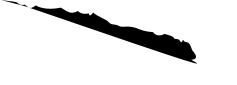

[-1.0193048  -0.10196082 -0.622219   -0.16202901 -0.7347967  -0.14737439
 -0.24651733  0.05374564 -0.03140305  0.8229808   0.03996566]
[-0.4146832   0.18186052 -0.70189196 -0.03156261 -0.58566356  0.02751695
  0.61477727 -0.03119564 -0.01667743 -0.01366483 -0.23859371]
[-0.35249338  0.2091746  -0.45349017  0.14901103 -0.3903597   0.17509602
  0.5274206   0.00564973 -0.0146975  -0.02277925 -0.02762624]
[-0.30604967  0.18231998 -0.40803     0.00909613 -0.43144667  0.02910537
 -0.46304497 -0.00111395  0.99403024 -0.00481021 -0.05892175]
[-0.35024965  0.16112341 -0.361026    0.15537947 -0.33846733  0.16969186
  0.49333102  0.0069029   0.01097643  0.01376962 -0.00733258]
[-0.38273227  0.18458766 -0.3656714   0.1438797  -0.38153297  0.14703996
  0.5185054  -0.0057017  -0.00162114 -0.00476254 -0.00847866]
[-0.37374312  0.22899126 -0.38174662  0.18802415 -0.3772477   0.21911153
  0.48768348  0.00056157  0.01726645  0.00209445  0.01095342]
[-0.36644006  0.19527194 -0.3624567   0.23526385 -0.363

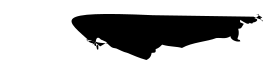

[-0.10156375  0.0829997  -0.25282302 -0.19777447 -0.26519197 -0.20722057
 -0.14949183  0.02768317  0.00959978  0.9728124  -0.6480416 ]
[ 0.07367948  0.16281298  0.00848853  0.11468583  0.05263419  0.14906257
  0.8434689  -0.01258771  0.00228021  0.01047251 -0.7107817 ]
[ 0.09732856  0.08212874  0.06797111  0.10848201  0.09994837  0.07799678
  0.77697927  0.00376347  0.00134327 -0.01032133 -0.54899466]
[ 1.60277009e-01  1.02934256e-01  1.64909765e-01  7.68312439e-02
  1.74825490e-01  1.02311857e-01  7.64731467e-01  4.50227788e-04
  4.68247756e-03  1.54982286e-03 -5.29879332e-01]
[ 0.08704624  0.06876833  0.15583844  0.05185306  0.12662214  0.06715304
  0.7351399  -0.00383957 -0.00702031 -0.00450813 -0.45033336]
[ 0.00839274  0.00936631  0.0876291   0.04013295  0.0694143   0.03350544
  0.7002311  -0.00393591 -0.00698402 -0.01427745 -0.36616465]
[-0.00834114 -0.04770147  0.01473871 -0.0218774   0.01418953 -0.0282356
  0.6462103   0.00281805  0.0040139  -0.00892047 -0.27620637]
[-0.0006544

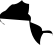

[ -61.185898 -494.31644   441.967     135.54222  -543.65796  1103.2994
 -281.16837   586.16705  1176.6788   -775.7588    -71.71002 ]
[-1112.6868   -2162.9988    1945.5278     113.922066   651.3081
  2502.5947    -756.7645     784.7014    2560.0828    2877.2883
 -1755.2903  ]
[ 1321.8094  -1799.0984   3335.5159   -358.3469  -2323.7954   2838.4758
 -2199.4094   2492.8298   2602.6025    308.71555 -2826.335  ]
[ -372.43344  -5024.069     3076.2727   -1038.6495    -153.88417
   256.577    -1044.9438    1134.1783    2345.5212    3375.6277
    -6.219102]
[  -10.618546  -489.54984   2272.954      479.13852  -1493.7418
  1405.558    -1084.4489     403.66675   1548.0194     585.74506
  -950.023   ]
[ -285.87683 -1987.4717   1473.6018   -141.05544  -123.56885  1985.2416
   237.84074  1630.4309   2679.558    1380.9098   -939.33234]
[   68.74621 -1261.3727   3226.0994    286.88074 -1340.8367   1904.2737
 -2156.324    1187.8026   1909.1445   1243.3907  -2588.7195 ]
[  380.51263 -7316.644    3709.693

[ 0.2525733   0.15118097 -0.2354831  -0.18468805 -0.2732013  -0.19234282
 -0.08124297 -0.01245227 -0.03938187  0.9956968  -0.76398605]
[ 0.32255694  0.17423175  0.32371116  0.1855811   0.3112117   0.18792057
  0.90555274 -0.00614121 -0.02301477  0.02104104 -0.80676275]
[ 0.18334065  0.06142549  0.2833574   0.11842445  0.2298774   0.08466325
  0.8394232  -0.00262656  0.00310381  0.00712295 -0.6492516 ]
[ 0.18607895  0.11171665  0.20701382  0.05861649  0.17607337  0.08830169
  0.8267746  -0.0091789   0.01296854  0.00162514 -0.65808195]
[ 0.18942608  0.16484283  0.19647567  0.11712322  0.19353746  0.1403879
  0.82430327 -0.00363526  0.00089195 -0.00616374 -0.63826513]
[ 0.19082645  0.19736777  0.20841259  0.17202488  0.2064445   0.16699015
  0.79056746 -0.00398051  0.00244085 -0.01095613 -0.5996618 ]
[ 0.04450566  0.22282322  0.16169953  0.22282001  0.13117304  0.23690616
  0.76683587 -0.00655491 -0.00138568 -0.02277608 -0.55617493]
[-0.2975486   0.21638349 -0.03517074  0.18261221 -0.1430

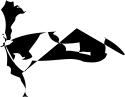

[-0.26134786 -0.49370527 -0.48581484 -0.6457178  -0.6021377  -0.6995498
 -0.16539077  0.05872326 -0.06567227  0.9536785  -0.34659997]
[ 0.16501623 -0.33746797 -0.01130327 -0.38040587  0.08790369 -0.3808394
  0.7579423  -0.02587474 -0.02260776 -0.00615124 -0.5212218 ]
[ 0.06852154 -0.3304048   0.07696997 -0.34428477  0.07645902 -0.3382113
  0.65886456  0.0096057  -0.00536904 -0.00525699 -0.28618962]
[ 1.44021869e-01 -3.08926821e-01  1.22418806e-01 -3.26063871e-01
  1.48198634e-01 -3.10615867e-01  6.53452277e-01  1.76323089e-03
  3.39539460e-04 -4.65468504e-03 -3.29374075e-01]
[ 0.06606466 -0.3140951   0.12235437 -0.32988417  0.10395858 -0.31245703
  0.6428907   0.00802015 -0.00358524  0.01012156 -0.31499055]
[-1.3763995e-01 -2.2194412e-01  1.1137820e-02 -2.8271458e-01
 -6.2792130e-02 -2.4806657e-01  6.4950442e-01 -1.3803496e-04
  5.6674704e-03 -2.8621913e-03 -3.0287087e-01]
[-2.8778887e-01 -1.5218592e-01 -1.8734880e-01 -1.9361910e-01
 -2.3863657e-01 -1.7381883e-01  6.4815837e-01 -1.2812

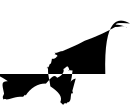

[ 0.6603979   0.53875226  0.06221334  0.08992413  0.05411776  0.09994991
  0.06223349  0.01028281  0.01101781  0.9585409  -1.0968333 ]
[ 0.58400995  0.45234898  0.60979307  0.5140497   0.59390354  0.5233242
  0.9917517   0.01244979  0.00617595 -0.01838812 -0.9935544 ]
[ 0.37116387  0.21231188  0.5149718   0.38627476  0.47697112  0.30585104
  0.9777799  -0.00955053  0.0153647   0.00283461 -0.941615  ]
[ 0.30797088  0.12211869  0.34365892  0.14967914  0.3180694   0.18963745
  0.94988304  0.0517125   0.01387662 -0.04200417 -0.9149523 ]
[ 2.6570490e-01  1.4259091e-01  2.8698346e-01  1.5371734e-01
  2.9299837e-01  1.3366394e-01  9.2374587e-01  3.3754117e-03
  2.0333586e-02  8.2905352e-04 -8.3608514e-01]
[ 0.16349594  0.13683133  0.22484018  0.15326002  0.20659891  0.15615463
  0.89449686 -0.00358243  0.00753211 -0.00514332 -0.8173234 ]
[ 0.09056662  0.09308255  0.13993357  0.10643838  0.12285741  0.10934335
  0.88004047  0.00136955  0.006847   -0.00228495 -0.7659729 ]
[ 0.08745892  0.054826

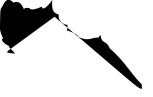

[-1.3348324  -0.33781967 -0.8100863  -0.32244948 -0.9428949  -0.32018355
 -0.2534366   0.03785653 -0.0496068   0.82136625  0.0680718 ]
[-6.8844157e-01 -2.8003404e-02 -8.2681483e-01 -2.6352286e-01
 -8.0925864e-01 -1.7051849e-01  6.1695737e-01 -7.6475088e-04
  1.7908838e-02  4.6815988e-02 -2.2791505e-01]
[-0.5290419   0.36340758 -0.6919752   0.04968309 -0.55871373  0.15322796
  0.5107771  -0.01403491 -0.03772635  0.00250732 -0.05788777]
[-0.4465816   0.34602445 -0.51496387  0.26133984 -0.4839572   0.26239946
  0.5567352  -0.00307915 -0.01407663 -0.02346612 -0.0755551 ]
[-0.43378267  0.35068327 -0.46562427  0.30920812 -0.44947684  0.33644193
  0.5274786  -0.00270823 -0.01272978 -0.0101039  -0.04750256]
[-3.1771365e-01  3.4804285e-01 -3.9487937e-01  3.4329969e-01
 -3.5051081e-01  3.4793717e-01  5.3615230e-01  2.2027903e-04
  7.2906744e-03 -7.9561854e-03 -6.1173405e-02]
[-0.24169125  0.35596484 -0.29356825  0.3514763  -0.26945752  0.35138884
  0.5510177  -0.00376814 -0.00170047 -0.01379255 

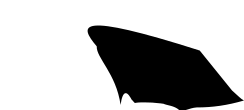

[-108.11013  -303.07367    90.560524   15.668601 -342.64413   452.1825
  -75.609665  338.63196   550.0304   -208.61328   -96.46042 ]
[-316.15646  -873.18463   901.9601     67.68045    40.833748  849.93317
 -303.9921    116.149086  789.2059   1104.894    -738.53906 ]
[ 138.14749  -204.00183   843.68726   -16.124542 -715.3521    670.58844
 -598.3454    779.04474   743.36725   202.692    -634.878   ]
[  43.069927 -776.7584    281.8566   -362.79648    50.3748    691.8221
  204.32855   568.8905    921.812     -74.96887  -294.45334 ]
[ -38.405964 -624.3082   1154.4935    350.32312  -412.6959    640.7577
 -582.8966    -58.899357  682.8423   1099.4873   -805.6312  ]
[  69.35316 -841.8078   596.1116  -361.17365 -176.86926 1027.8948
  107.22614  882.7006  1366.016    193.66151 -408.45102]
[  -56.31439  -696.194    1449.8815    199.91057  -600.21814   788.28143
  -695.5678    278.958     792.5386    808.7313  -1003.16254]
[  -21.912071 -1012.7128     734.8689    -186.45508    -71.46609
   822.850

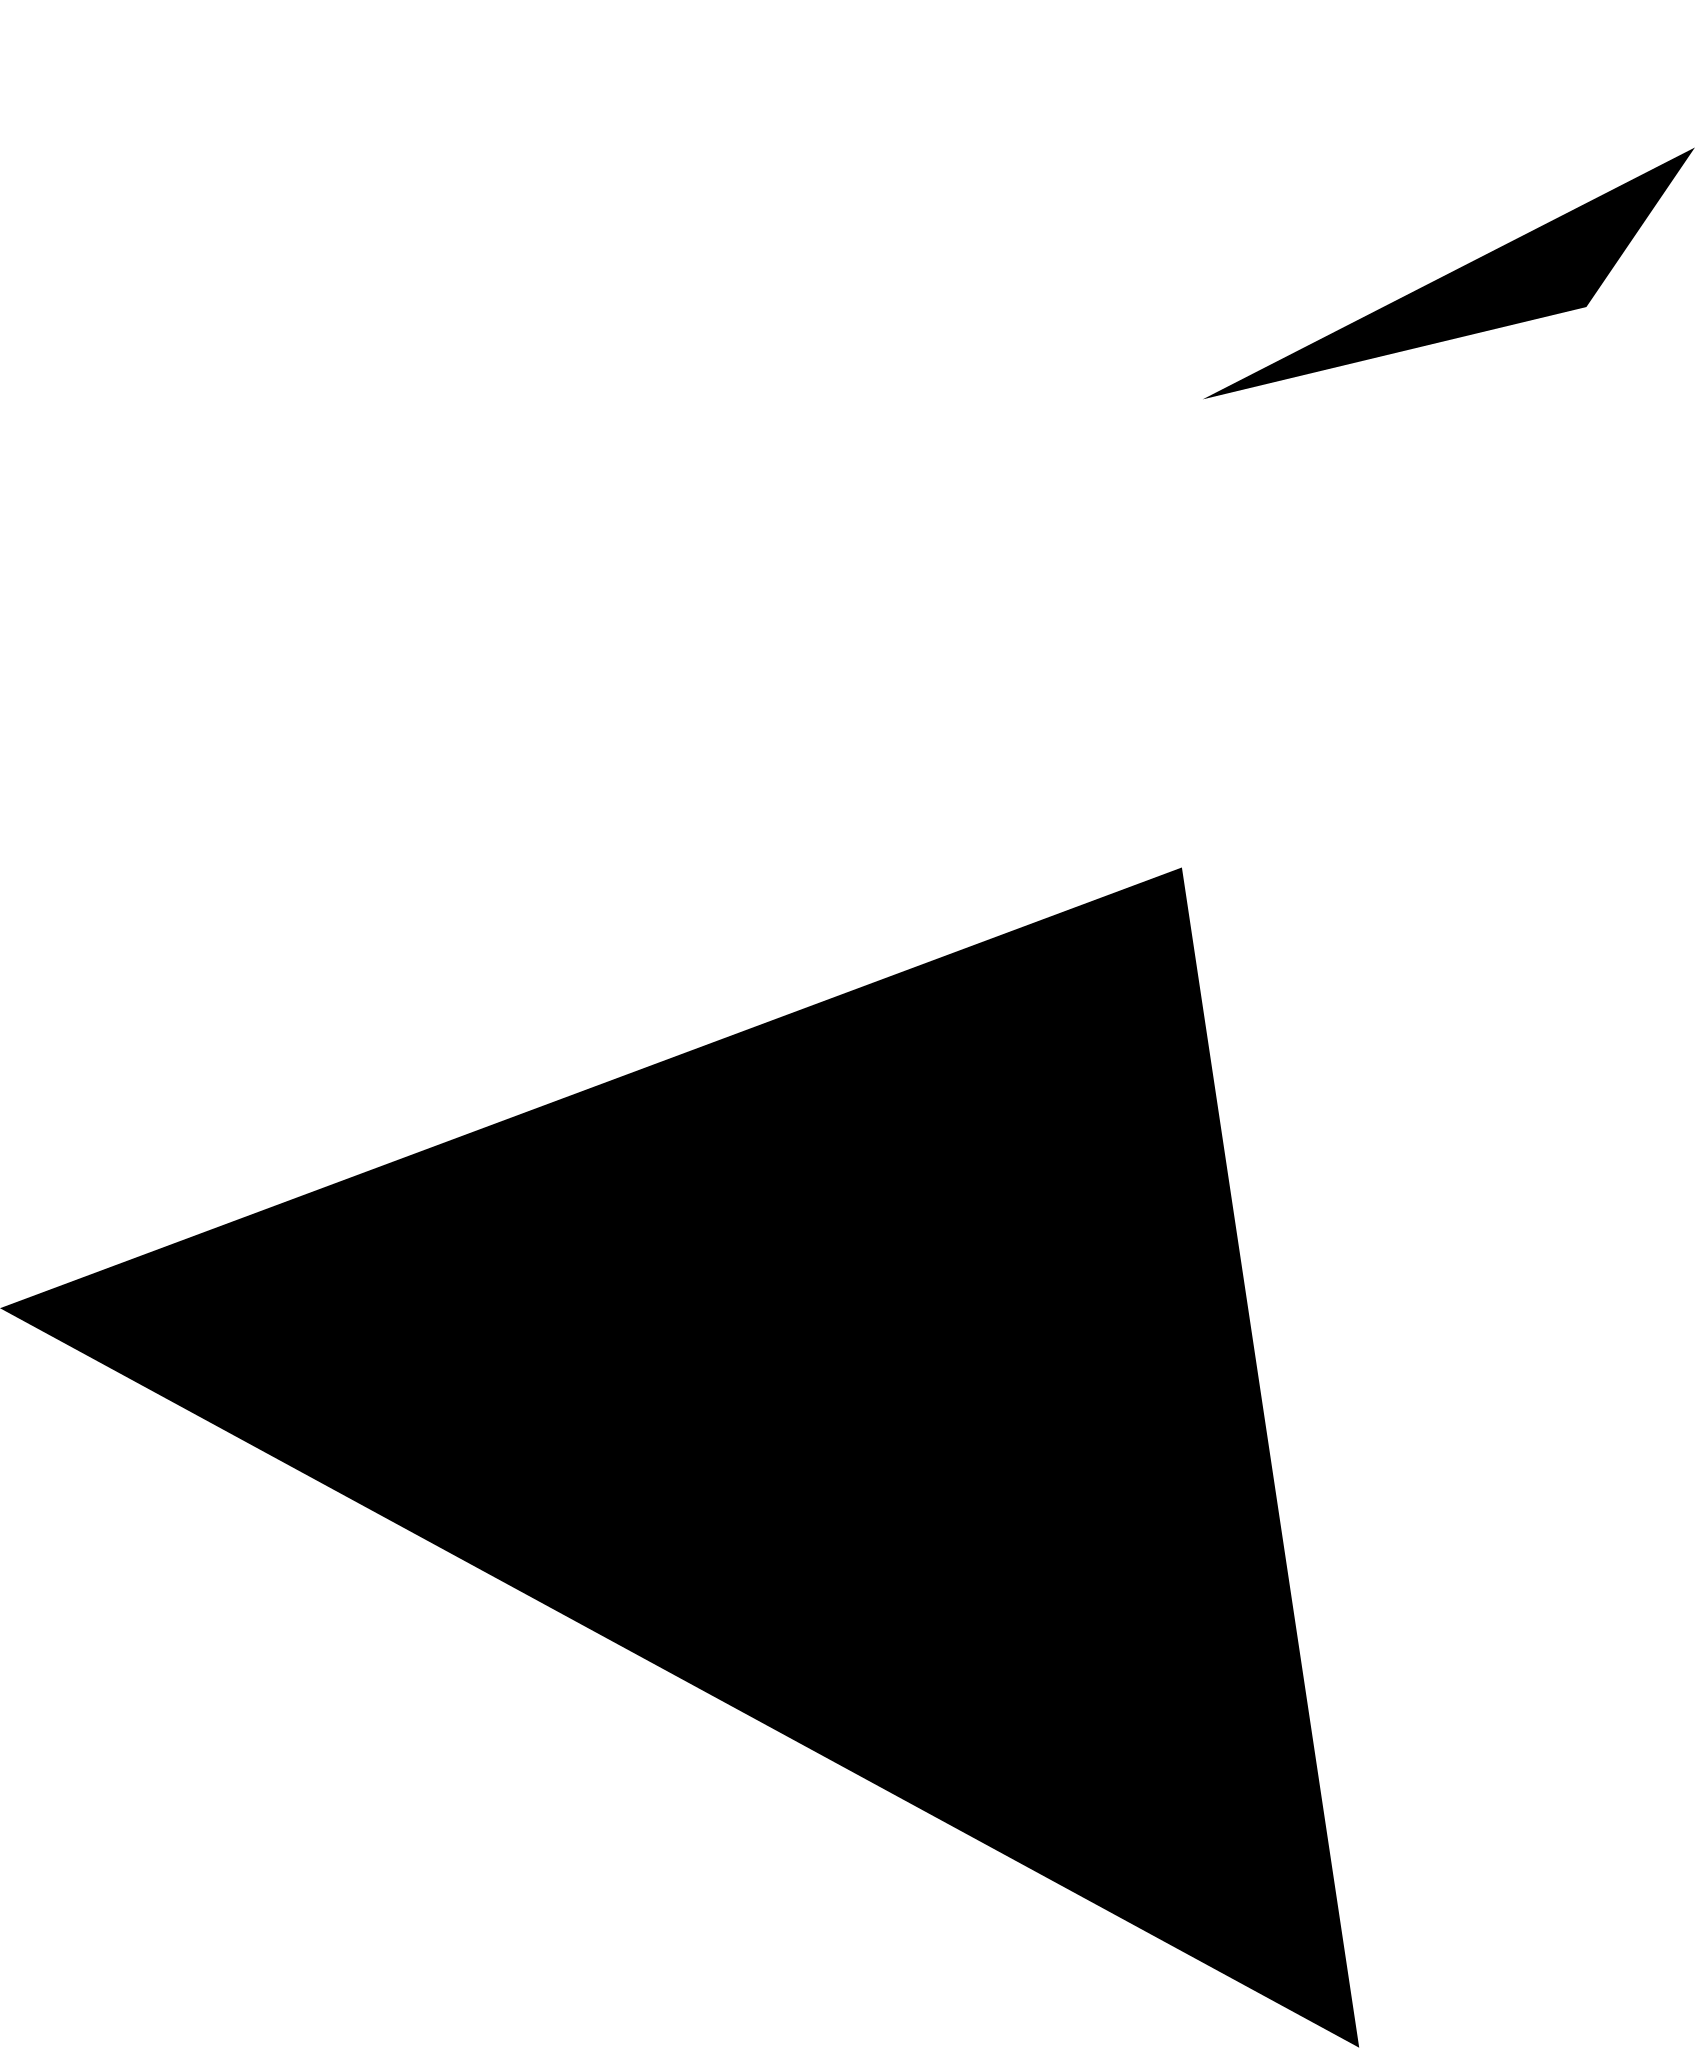

[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[-0.6655744  -0.16400553 -0.33362406 -0.24099606 -0.42350188 -0.30782273
 -0.08699446  0.04256393 -0.01928182  0.9374496  -0.52050847]
[-0.2695279   0.00336086 -0.42787763 -0.14257681 -0.34887025 -0.12059461
  0.8238126  -0.02403131 -0.01070343 -0.01710316 -0.66558343]
[-0.25860304  0.02052333 -0.27776977 -0.01198947 -0.271      -0.01869185
  0.7693847   0.00762914  0.00522066 -0.00659996 -0.5237496 ]
[-0.1898151   0.07923514 -0.21068925  0.01474876 -0.19522254  0.04501283
  0.77318436 -0.00814706 -0.00498013 -0.0068942  -0.5443637 ]


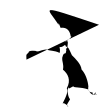

[-0.8495314  -0.3238868  -0.51976395 -0.38117173 -0.6509601  -0.43662387
 -0.19420286  0.05042958 -0.0303246   0.8871279  -0.2468236 ]
[-0.31254494 -0.05724839 -0.53659093 -0.21032862 -0.4191168  -0.13718292
  0.7016513  -0.01530506  0.00361528 -0.01905088 -0.4532296 ]
[-0.30305257 -0.08998745 -0.33173215 -0.06590773 -0.30283588 -0.08669094
  0.640846    0.01102463 -0.00622492 -0.01876439 -0.24120685]
[-0.22044657 -0.11218552 -0.2399372  -0.12058377 -0.21685386 -0.10849042
  0.6391642   0.01014473 -0.01328673 -0.00167304 -0.28266555]
[-0.25432637 -0.14659365 -0.20851207 -0.1590513  -0.21082552 -0.1395918
  0.6414024   0.00759265 -0.00232694  0.00138118 -0.2681346 ]
[-0.21520598 -0.0988624  -0.23503388 -0.14666934 -0.2213477  -0.12447331
  0.6252764   0.0048766  -0.00519725 -0.0090855  -0.26636356]
[-1.8312056e-01 -5.1971119e-02 -1.9589368e-01 -9.8832831e-02
 -1.8160164e-01 -6.7503996e-02  6.3425839e-01  5.0889119e-03
 -1.4896881e-03  4.6925541e-04 -2.6886153e-01]
[-1.4188142e-01 -1.554

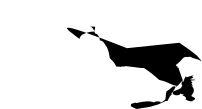

[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[-26.042557   -15.146159   -34.12239     -0.31675592 -33.483418
  -7.04583     -8.209221    -3.008331     7.752345     1.735655
 -15.922968  ]
[-3.028049  -5.0222154 -2.6629262 -2.1192217 -3.546879  -3.0628974
 -4.568656   0.5589385  1.3445109  0.8812716  2.3287604]
[-0.08677475 -1.452143    0.31518877 -0.84525037 -0.10493476 -1.0206285
 -1.3582267   0.42571384  0.20707865  0.31859943  1.7063398 ]
[ 0.04853744 -0.13423492  0.05139864 -0.13243699  0.04757961 -0.13325933
  0.38254544  0.04262462  0.02405412  0.03036792  0.00618528]
[-0.

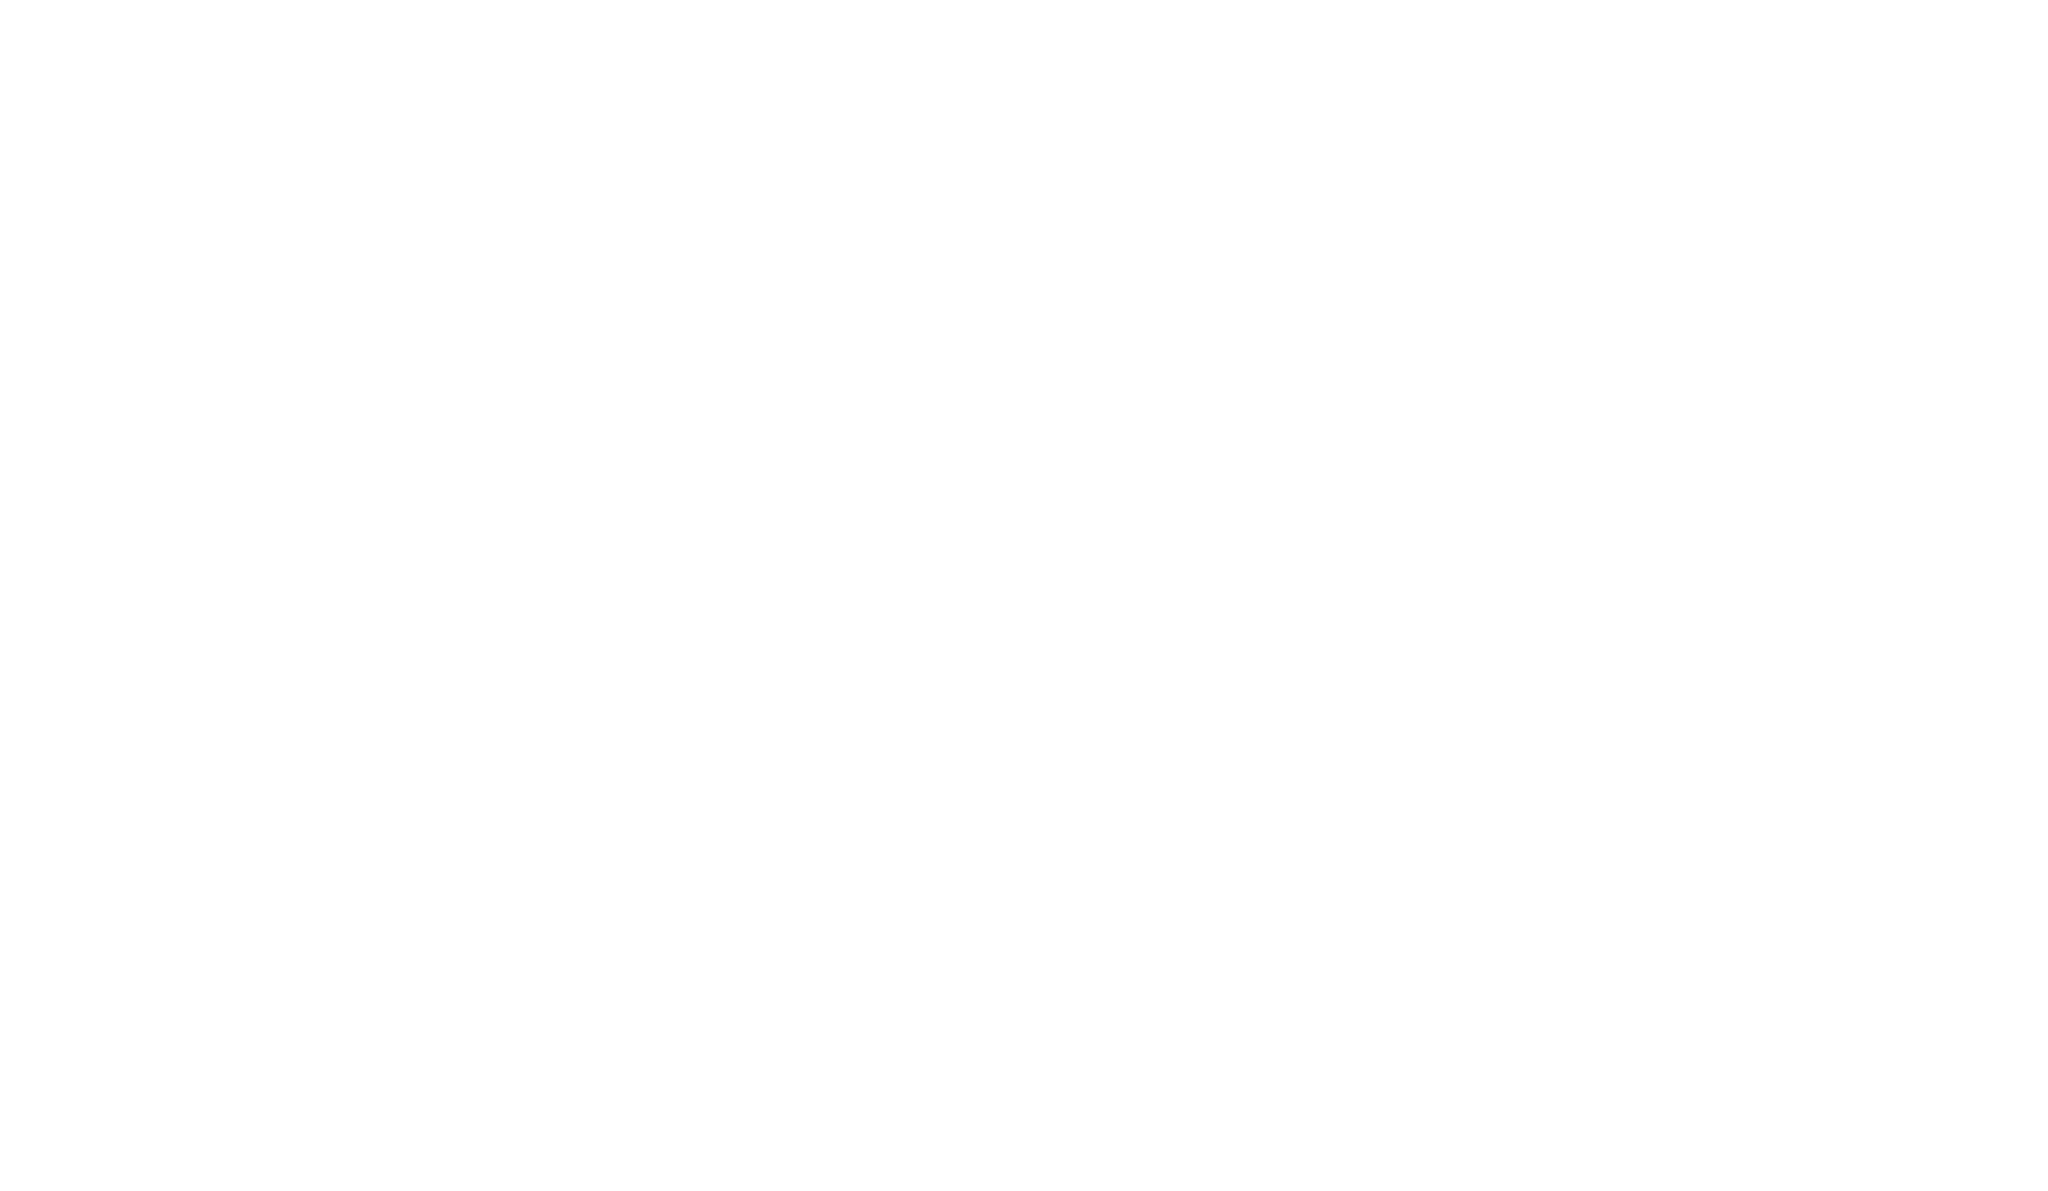

[ -152.44685   -993.489      587.24774    107.389755  -973.037
  1671.5757    -356.2212     874.8407    1922.5319   -1384.2454
  -218.1907  ]
[-1985.9583 -3448.297   3359.0652   356.6256  1091.8923  3851.049
 -1296.7521   980.9856  4157.358   4855.9497 -2933.4211]
[ 1441.1357  -2043.6743   5029.974    -765.79065 -3467.068    4448.4756
 -3454.0999   4133.085    4188.9077    205.66394 -4029.2793 ]
[  -35.61166  -6614.462     3892.0276   -1502.6798    -308.08618
  2241.5554     -62.480194  2049.5952    4036.2053    3948.0535
 -1729.7073  ]
[  -64.10583 -1586.0085   4568.0825   1025.7035  -2743.7722   2667.0823
 -1746.2463    373.16135  2887.6516   2492.7656  -2062.0845 ]
[ -435.1016  -3852.129    2497.0798   -306.92538  -159.05363  4211.5537
   508.31296  3619.441    5439.6045   2177.3386  -1553.7936 ]
[  -27.756247 -3054.461     7091.572      571.4445   -2933.2473
  4239.562    -4296.418     2125.1455    4048.161     2815.306
 -5411.929   ]
[   334.0882  -14410.803     7717.865    -6490.

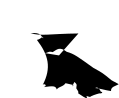

[-6.5197207e+23 -5.8502563e+23 -7.2033188e+23 -1.1369870e+23
 -8.0190814e+23 -3.1799495e+23 -5.7364539e+23 -7.8603836e+20
  2.8343874e+23  9.7869642e+22 -4.9753909e+22]
[-1.02786541e+24 -1.01911055e+24 -1.13093371e+24 -2.52727528e+23
 -1.26327757e+24 -5.78649430e+23 -9.95328520e+23  1.47801441e+22
  4.21849151e+23  1.78719208e+23  2.10135819e+22]
[-4.4089322e+23 -4.1517175e+23 -4.3055609e+23 -1.1005733e+23
 -5.3141341e+23 -2.3522232e+23 -4.6800024e+23  1.0706464e+22
  2.1657288e+23  7.0786052e+22  3.0767010e+22]
[-2.9269501e+24 -1.9305672e+24 -3.7790107e+24  6.0674752e+21
 -3.7460143e+24 -8.1320763e+23 -1.1444980e+24 -2.7155520e+23
  9.6824142e+23  1.4273922e+23 -1.5678838e+24]
[-1.9873782e+23 -1.4732757e+24  5.3097735e+23 -7.3682572e+23
  1.6571701e+22 -9.0000547e+23 -2.0798894e+24  4.3352068e+23
  4.2705675e+23  3.6053034e+23  1.9353595e+24]
[-1.01117499e+25 -5.51532456e+24 -1.37940279e+25 -3.55767437e+23
 -1.36177266e+25 -2.70566840e+24 -3.41190978e+24 -1.03913644e+24
  3.29923563e+

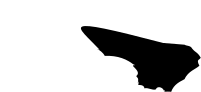

[-0.00395606  0.37051678  0.00661448  0.03307349  0.01395745  0.00652405
 -0.00165812 -0.03595118 -0.03419693  0.9911546  -1.0915617 ]
[-0.04358044  0.30037323  0.00625591  0.32247698  0.00266445  0.3171401
  0.9520289  -0.00501353  0.02262095  0.00401851 -0.9321956 ]
[-0.05305948  0.08539443 -0.0182278   0.2227957  -0.01831174  0.17756331
  0.9505776   0.00220285  0.01013155 -0.02552388 -0.86634696]
[-0.07069115  0.0544072  -0.05536144  0.0722991  -0.04783864  0.05963432
  0.8936597  -0.01402201  0.01278969 -0.00712978 -0.8030264 ]
[-0.13160092  0.03899669 -0.10520949  0.01867971 -0.09342381  0.03105096
  0.86403185 -0.00366206 -0.00272252 -0.01712545 -0.72089213]
[-0.22810942  0.10439103 -0.17346796  0.04347082 -0.17738788  0.0841957
  0.83333373 -0.00273072 -0.00896843 -0.01420001 -0.662422  ]
[-0.3075531   0.16047212 -0.27430588  0.1044212  -0.26754653  0.11692344
  0.8023737  -0.0045553  -0.01135217 -0.01143686 -0.584961  ]
[-3.5772789e-01  1.9737865e-01 -3.4991759e-01  1.5536839e

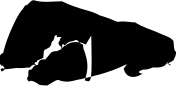

[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[ 1.8233886e+34 -1.9540470e+34  4.3461678e+34  1.3543109e+34
 -5.0022364e+34  9.6065860e+34 -3.4621798e+34  5.8358969e+34
  8.3317128e+34 -1.8841683e+34 -5.1688979e+33]
[-2.8997844e+34 -1.4342945e+35  1.1745998e+35 -6.0862115e+32
 -8.6519239e+33  1.3966856e+35 -2.1154551e+34  5.4633329e+34
  1.0934065e+35  1.3011265e+35 -8.9867039e+34]
[ 2.4764810e+34 -9.5905869e+34  1.6783084e+35  8.8685638e+32
 -9.5626788e+34  1.4413397e+35 -8.8051654e+34  8.9935245e+34
  1.1879261e+35  7.2775266e+34 -1.1987051e+35]
[-5.5734258e+33 -1.5536709e+35  1

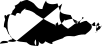

[-0.595572   -0.17798373 -0.09313436 -0.27926925 -0.4290811  -0.3475809
 -0.5552843   0.03615457 -0.08957271  0.8505414   0.7984363 ]
[ 0.33118796 -0.08120929 -0.23150738 -0.02322469  0.13013913  0.00192565
  0.48319802 -0.00081808  0.19246536  0.00449073 -0.43994504]
[ 0.29153317 -0.16628748  0.31496292 -0.10432122  0.30019066 -0.13392904
  0.45993754  0.0140886   0.02088647 -0.01830929  0.0614904 ]
[ 3.1396669e-01 -6.8190448e-02  3.0840483e-01 -9.7205661e-02
  3.0176485e-01 -6.8599366e-02  3.9923030e-01  1.2927752e-03
  1.0740688e-03  3.0213545e-04  1.6291635e-01]
[ 0.2790765  -0.1011819   0.32648957 -0.09321936  0.2888908  -0.07878486
  0.41453502 -0.00367421 -0.00905214  0.00885202  0.1397454 ]
[ 0.30009153 -0.09058648  0.2830608  -0.09245743  0.28571975 -0.06695661
  0.39590317  0.00162736 -0.0040575  -0.00322069  0.1864504 ]
[ 0.31108555 -0.07270927  0.31627846 -0.07077164  0.30970338 -0.05940253
  0.37962493  0.00292384  0.00104162 -0.00524135  0.2311768 ]
[ 2.5387228e-01 -6.465

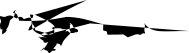

[-1.0666222e+19 -1.1686664e+19  2.0829353e+19  2.7605870e+18
 -2.2679481e+18  2.6176405e+17 -4.5006943e+19  8.5408046e+18
  3.1621873e+19  3.1340985e+18  2.9222473e+19]
[-1.82391746e+21 -1.00089068e+21 -2.45780516e+21 -1.15021000e+19
 -2.39313459e+21 -4.98391240e+20 -6.01694562e+20 -2.27781584e+20
  5.69937816e+20  1.22008742e+20 -1.17547666e+21]
[-1.1152814e+19 -1.5285620e+19  1.9660790e+19 -1.2242169e+19
 -4.9557078e+18 -1.1891869e+19 -5.0886524e+19  7.6309202e+18
  2.1627739e+19  2.2121869e+18  2.8469879e+19]
[-2.14121885e+21 -1.16645785e+21 -2.91154563e+21 -5.90816240e+19
 -2.86194637e+21 -5.80025668e+20 -7.18990392e+20 -2.37781581e+20
  6.87230585e+20  1.77019806e+20 -1.40966440e+21]
[-1.29415025e+20 -1.04698954e+20 -1.72209733e+20  3.29890916e+19
 -1.99471834e+20 -6.26949315e+19 -7.02322992e+19 -1.76637994e+19
  1.93560952e+19  9.98899057e+18 -1.27146883e+20]
[-1.7017813e+19 -2.0316005e+20  7.8568075e+19 -9.9518653e+19
  1.0262823e+19 -1.2587271e+20 -2.7771481e+20  6.3399644e+19


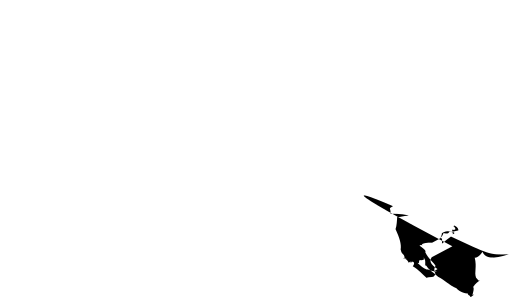

[-3.2947018  -0.7378868  -3.3161387   0.3510023  -3.3569605  -0.09814067
 -0.9150478  -0.19863006  0.6250848   0.80462277 -0.8837165 ]
[-0.9181029   0.2454724  -0.850938    0.285254   -0.78980047  0.25105855
  0.21541202 -0.01419207  0.02620076  0.02767631  0.33600378]
[-1.9025058  -0.59045976 -2.3048239   0.2381898  -2.2252145  -0.16732763
 -0.03120852 -0.16521782  0.40549773 -0.02281578 -0.4760449 ]
[-0.07418166 -0.00221238 -0.47536385  0.07553656 -0.26656616  0.05450429
  0.44202542 -0.01441623 -0.00700365  0.01726737  0.15001078]
[-3.0816108e-01  8.3467318e-04 -1.7812113e-01 -9.3091335e-03
 -2.5547749e-01  9.8538520e-03  4.0322357e-01 -8.9486406e-05
  1.2371540e-02  1.7247161e-02  1.4474255e-01]
[-0.29006794  0.04526459 -0.2775913   0.05267745 -0.28194022  0.05188606
  0.43139455  0.00383522  0.01867279 -0.00211149  0.07038452]
[-0.31073105  0.01330748 -0.28646117  0.05077367 -0.295161    0.02971899
  0.48326433 -0.00351155  0.00959948  0.02513188 -0.00283187]
[-0.30740267 -0.03128

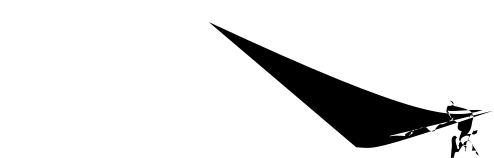

[ 0.58616704 -0.04243817 -0.23309731 -0.30200222 -0.27510795 -0.31368685
 -0.11796162  0.02106437 -0.04041293  0.99077666 -0.6431562 ]
[ 0.7732185   0.11859922  0.68974614  0.07010259  0.73703116  0.08441537
  0.8830374  -0.01616893  0.00343745 -0.001566   -0.78121954]
[ 0.7631597   0.08906722  0.7314844   0.10044079  0.73783034  0.11062718
  0.8297461  -0.00709179  0.0114136  -0.00127857 -0.66413265]
[ 0.59307265  0.09855219  0.72428316  0.11489341  0.64052767  0.1075601
  0.83009624  0.00323767  0.00863671  0.00680254 -0.6874487 ]
[ 0.42926514  0.09100207  0.54950106  0.10415661  0.4840837   0.09327048
  0.8557694  -0.00275531 -0.00354209  0.00412337 -0.7077273 ]
[ 0.42975688  0.08561323  0.44137514  0.08533031  0.43403664  0.08954193
  0.8492788   0.00199267  0.01130712 -0.00546419 -0.73598194]
[ 0.41102162  0.08368374  0.42084214  0.06998534  0.42811897  0.06895497
  0.8835405  -0.00495021  0.00627067 -0.0049954  -0.7709761 ]
[ 0.3126897   0.09417616  0.39112675  0.05471548  0.3824

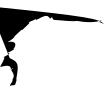

[-1.3403685   0.14727485 -0.63162833  0.14660135 -0.7925185   0.25252977
 -0.41297424  0.05925998  0.01041435  0.82754415  0.36154106]
[-0.846213    0.21655178 -0.7806963   0.21135594 -0.7172179   0.16831496
  0.43649185 -0.02119344  0.04487474  0.04448273 -0.12794402]
[-0.75655746  0.08358978 -0.7716338  -0.11960717 -0.77131003 -0.17259218
 -0.52246475 -0.01419247  1.0221323   0.02105013 -0.01942565]
[-0.6404843   0.08939259 -0.7310754   0.10139807 -0.68932253  0.12923564
  0.4725375  -0.017497   -0.02397769  0.00819972  0.0055272 ]
[-0.6225452   0.07720471 -0.6481305   0.07082413 -0.6542908   0.06322519
  0.5093443  -0.00992339 -0.01735932  0.01721471 -0.02189505]
[-0.5602622   0.09270506 -0.59960306  0.07454926 -0.58620363  0.09321131
  0.5107407   0.00239107 -0.0011679  -0.00636729 -0.03384661]
[-0.426269    0.09526455 -0.4929462   0.09469989 -0.45894015  0.08887911
  0.52928615  0.0010142   0.00181503 -0.0167872  -0.05871972]
[-0.40868357  0.11093697 -0.43522865  0.08205401 -0.421

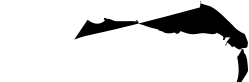

[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[ 0.90609276  0.30802172 -0.06733786 -0.02589911 -0.07739334 -0.00984697
 -0.07196687  0.01973661 -0.02717042  1.003058   -0.84883827]
[ 0.91915274  0.34476787  0.91234916  0.34277192  0.9038588   0.3459959
  0.9364312  -0.01914619  0.00260193  0.00511929 -0.87819755]
[ 6.8200999e-01  1.7332053e-01  8.4540498e-01  2.7716276e-01
  7.6686347e-01  2.2055218e-01  8.9099473e-01 -2.1791386e-03
  8.4241247e-03 -5.3874135e-04 -8.2789242e-01]
[ 0.49516436  0.11138721  0.61139077  0.15773022  0.5494392   0.13933516
  0.8862337   0.00115096  0.0

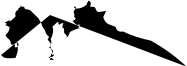

[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[-27.093725   -14.911378   -35.7469      -0.46137145 -34.988914
  -7.6665115   -8.807853    -3.3103426    8.126453     2.444429
 -16.642912  ]
[-1.879361   -1.3179445  -2.8283045   0.04644781 -2.8713672  -0.8749803
 -0.2094861  -0.3221243   0.36553696  0.15881582 -1.7058657 ]
[ 0.05890883 -0.54958415  0.11320264 -0.26137936 -0.01451811 -0.38133198
 -0.2624309   0.16845632  0.11324833  0.13555965  0.604798  ]
[ 0.316163   -0.09032543  0.18497404 -0.06289554  0.21821043 -0.06518333
  0.5249443   0.00453434  0.00184346  0.00932152 -0.103

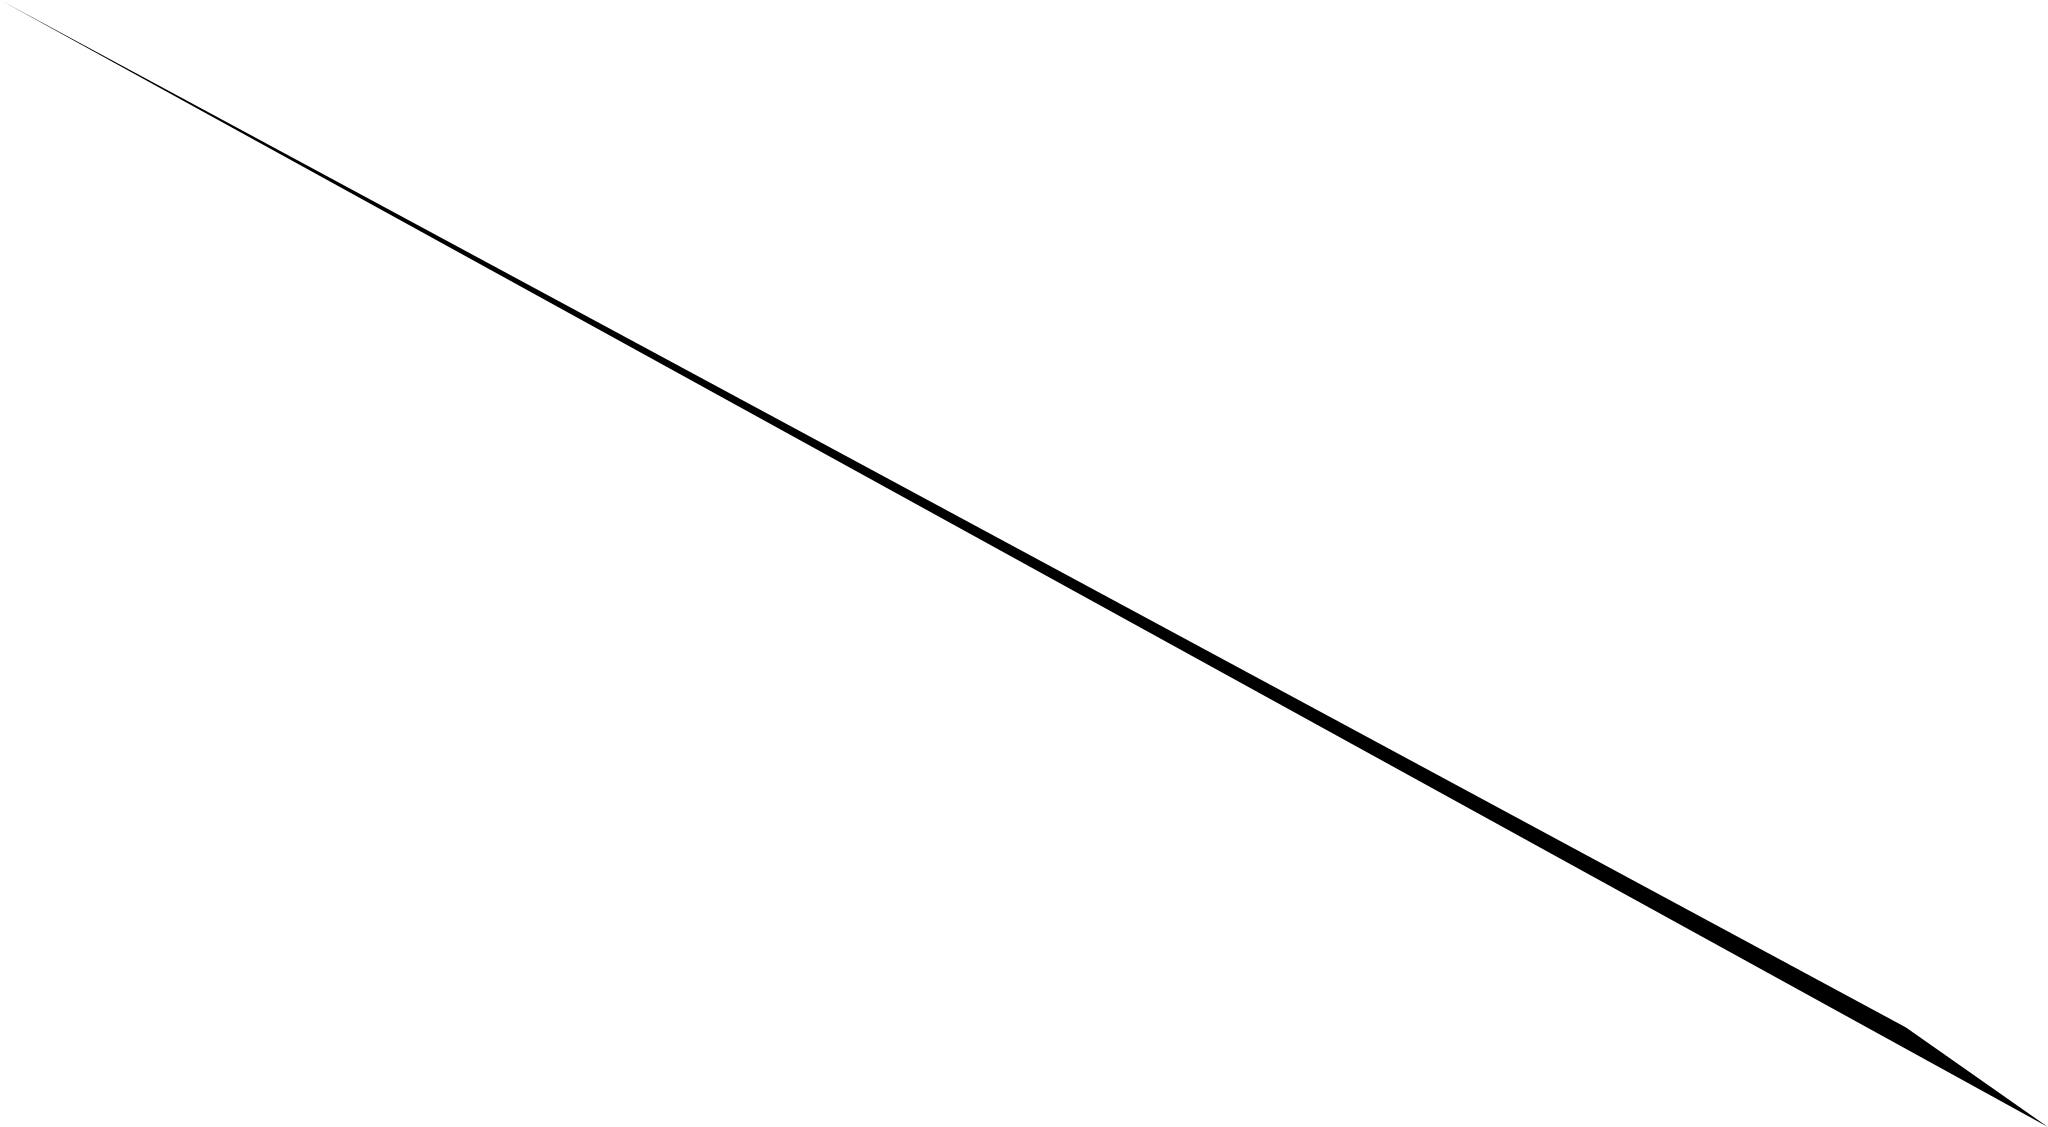

[ -136.6751    -994.73236    437.30322   -427.30414     21.462317
  -565.8675   -1477.3766     338.2346     393.1532     250.76234
  1386.1484  ]
[-12178.046    -6603.807   -16521.03      -427.07977 -16325.236
  -3274.0657   -4100.2554   -1285.2677    3964.1814    1105.1881
  -8069.437  ]
[ -733.16583  -783.1363   -890.3448     97.92081 -1138.6859   -432.31583
  -632.8638    -74.46879   143.8968     91.05266  -496.46732]
[-39.553646   39.902306   63.857788   34.09721   -16.615986   70.960594
 -75.66637     8.530881  126.68637   -16.97742   -11.5887785]
[-7146.2065  -4213.2607  -9426.166     184.57817 -9198.19    -1732.776
 -2218.3342   -808.85516  2273.6165    254.70445 -4464.077  ]
[ -164.26262  -1606.073      700.1956    -878.98553     58.438553
 -1011.5121   -2316.9155     497.5108     459.02823    385.13803
  2201.2466  ]
[-14685.917   -8003.738  -19985.285    -469.3027 -19711.244   -3960.5715
  -4963.428   -1583.4673   4750.0913   1278.2924  -9721.317 ]
[  59.10213   -139.2084    

[-1.5134834   0.52240676 -0.8303935   0.51750374 -0.93077993  0.5747277
 -0.73494273  0.01361667  0.28209355  0.6968918   0.69333655]
[-0.9581901   0.28500098 -0.8801768   0.5127842  -0.8050443   0.40610337
  0.18039468 -0.06607058  0.00989386 -0.027798    0.4667508 ]
[-0.8279049   0.21837394 -0.91145194  0.37338582 -0.9399234   0.33925283
  0.2987161  -0.02570049  0.0138401   0.03601762  0.24126539]
[-0.46200588  0.04187859 -0.73185754  0.18460917 -0.6354101   0.13569233
  0.339557   -0.00906477 -0.01806716  0.01143265  0.29250333]
[-0.55382043  0.08241628 -0.545106    0.08115631 -0.57346874  0.0772756
  0.31905448 -0.00183139  0.01332794  0.0190828   0.31535372]
[-0.5461008   0.13753392 -0.5534915   0.10941762 -0.5506958   0.12755145
  0.35959807 -0.01026495  0.00055424  0.00089092  0.31275132]
[-0.5548319   0.13900867 -0.55386734  0.16022201 -0.5498854   0.13572133
  0.34357926 -0.00774209  0.0008888  -0.01188218  0.29474244]
[-0.51815546  0.12173881 -0.5470946   0.14650318 -0.52281

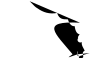

[-1.8612537e+12 -1.7423807e+12  1.7366478e+11  1.2627821e+12
 -1.5131657e+12  6.0857778e+11 -3.0000071e+12  9.0994678e+11
  3.2374737e+12  7.6508447e+10  1.3172165e+12]
[-1.5226432e+14 -8.3530185e+13 -2.0458364e+14 -2.4296463e+12
 -2.0088879e+14 -4.0871173e+13 -5.0536762e+13 -1.7747788e+13
  4.8760835e+13  1.2292397e+13 -9.9348625e+13]
[-1.4958697e+12 -1.6358451e+13  6.2422867e+12 -8.0592671e+12
 -6.6607913e+11 -1.0006619e+13 -2.2045977e+13  5.1292338e+12
  3.6120313e+12  3.6465014e+12  1.9267058e+13]
[-3.2731201e+13 -5.0893030e+13 -2.7793660e+13 -2.4265456e+13
 -4.2724640e+13 -3.0344332e+13 -6.1595967e+13  8.9446962e+12
  1.9506787e+13  1.2570769e+13  2.6077313e+13]
[-1.9683105e+14 -1.0841013e+14 -2.6709318e+14 -6.1495742e+12
 -2.6295885e+14 -5.4066500e+13 -6.6050134e+13 -2.0834515e+13
  6.3239161e+13  1.8139119e+13 -1.2904330e+14]
[-6.2768087e+11  9.3182126e+11  3.0937189e+12  8.8207530e+11
  6.0919833e+10 -1.5740257e+12 -4.1550188e+12  1.4268654e+12
  9.4496856e+11 -1.9104034e+11 -3

[-1.68707113e+11 -9.95389358e+10 -2.23541592e+11  5.56962714e+09
 -2.17046712e+11 -4.08600494e+10 -5.22794926e+10 -1.87376210e+10
  5.41385974e+10  6.11850138e+09 -1.04758714e+11]
[-4.2231390e+10 -4.9125003e+10 -4.0132948e+10 -9.3844296e+09
 -5.0223325e+10 -2.2778278e+10 -4.5081670e+10  3.5878351e+09
  2.0272708e+10  7.5017103e+09  7.5372564e+09]
[ 2.2087145e+09 -1.4670227e+10  7.3934505e+09 -7.0941875e+09
 -1.6645907e+09 -4.6012216e+09 -2.1066873e+10  9.0464686e+09
  5.9112038e+09  3.0551084e+09  1.3121381e+10]
[-1.4567748e+10 -1.6970721e+10 -1.6255899e+10 -1.0829491e+10
 -2.3375710e+10 -8.8990249e+09 -1.7569001e+10  4.8490721e+09
  8.0858373e+09  7.6417167e+09 -1.8959027e+08]
[-1.08051200e+09  1.07150816e+09  1.20625690e+09  8.27750272e+08
  1.55347728e+08  1.58379341e+09 -2.05667507e+09 -2.58723040e+08
  2.64715494e+09 -1.96241312e+08 -3.95544160e+08]
[-1.9488860e+11 -1.0681772e+11 -2.6256674e+11 -9.1791840e+08
 -2.5601902e+11 -5.2904653e+10 -6.5242505e+10 -2.4423346e+10
  6.1451432

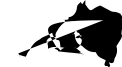

[-0.79772234 -0.28804666 -0.66541845 -0.32621956 -0.8010797  -0.37830427
 -0.1676061   0.03334488 -0.00614868  0.8590828  -0.34261423]
[-0.03525391 -0.03936674 -0.3618542  -0.12960352 -0.2016203  -0.10043474
  0.7423406  -0.02208259 -0.02100901  0.00724169 -0.49328005]
[ 1.0849286e-04 -6.3915566e-02 -5.6940962e-02 -5.0220758e-02
 -2.5111442e-02 -6.9106303e-02  6.6568041e-01 -1.8173545e-03
  2.2478991e-03 -6.9969576e-03 -3.1600904e-01]
[ 0.22546929 -0.04068067  0.11715577 -0.05548118  0.15853427 -0.0441839
  0.6855741  -0.00326158 -0.00612604  0.01606116 -0.41537917]
[ 0.20022865  0.00418624  0.21390279 -0.02757392  0.20517208 -0.00099856
  0.6924825   0.00173866 -0.00498249  0.01415163 -0.40958557]
[ 0.23366278  0.04751725  0.21840988  0.0383159   0.20663257  0.03359316
  0.7189965   0.0013886  -0.00305144 -0.00575655 -0.44453198]
[ 0.2583986   0.0590445   0.25714833  0.05875771  0.25585902  0.05521946
  0.7436083  -0.00493459 -0.00292801  0.0013305  -0.48515046]
[ 0.26257086  0.042469

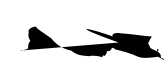

[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[nan nan nan nan nan nan nan nan nan nan nan]
[-0.32985917  0.151022   -0.17336057 -0.17657983 -0.21864986 -0.19934155
 -0.05002548  0.00317914 -0.02588288  0.9304367  -0.6866808 ]
[-0.18221976  0.21817394 -0.26788804  0.1109748  -0.22344197  0.17117964
  0.8279324  -0.02099353 -0.01345191 -0.00596347 -0.6528273 ]
[-0.13934411  0.1857141  -0.18903328  0.20511764 -0.1580518   0.17904843
  0.77674913  0.00520203  0.00640705 -0.01940251 -0.5322515 ]
[-0.08340633  0.18121651 -0.09385831  0.16854416 -0.0811614   0.18338488
  0.75299525 -0.01021851 -0.00379787 -0.00569958 -0.49363077]


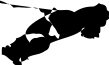

[-1.3914127  -0.33600417 -0.71741706 -0.39900503 -0.9099205  -0.39414242
 -0.30408144  0.06125676 -0.07234105  0.9177821   0.04827071]
[-0.5909621  -0.10491411 -0.8721342  -0.25228304 -0.6885786  -0.2230433
  0.61694336 -0.03073675  0.01190131  0.02851295 -0.37376156]
[-0.49364647 -0.17777601 -0.61514896 -0.11674982 -0.5485836  -0.15276977
  0.6195742   0.00176802  0.00964114 -0.02138548 -0.2016295 ]
[-0.2683884  -0.2358483  -0.37740412 -0.21880604 -0.34147796 -0.22991963
  0.6007083  -0.00510667 -0.008013    0.00933725 -0.22293414]
[-3.0415779e-01 -2.2312318e-01 -2.9281598e-01 -2.5154489e-01
 -3.1468070e-01 -2.3237129e-01  5.9985715e-01 -9.3086570e-04
  3.1822553e-04  1.0455277e-02 -1.9593400e-01]
[-0.3031991  -0.17594914 -0.29287967 -0.20640822 -0.30082643 -0.18738042
  0.6043162  -0.00254203 -0.00683658  0.00212618 -0.18210101]
[-0.28011754 -0.13004923 -0.2957676  -0.15662844 -0.28103304 -0.1418033
  0.6132975  -0.00120593 -0.01405647  0.00254013 -0.1987293 ]
[-0.23959571 -0.0581193

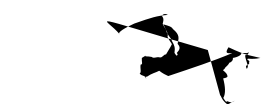

[-373.54926   -204.30432   -503.67572     -4.6154065 -491.81305
 -101.859055  -123.7041     -45.201153   117.04489     27.006233
 -240.77502  ]
[-18.313211  -16.060436  -23.370707    3.4340289 -27.065235   -9.450454
 -10.392571   -1.8561954   2.8100796   2.8219159 -16.979177 ]
[ 0.5377857  -3.2190533   3.5859325   0.5698921  -0.71037066  2.628622
 -5.29874     1.6213593   3.311573    4.1173825  -2.6577296 ]
[-0.2186389  -3.0370371   2.2078648  -0.6239618  -0.7043255   6.665021
 -0.95825917  3.9780862   6.155417   -1.0845267  -0.92175984]
[ 0.72453004 -5.130472    7.2220554   2.554095   -2.3352625   6.0751977
 -4.5308375   1.8726007   5.7025957   8.103183   -6.052515  ]
[ 1.0478928  -5.9062634   4.985531   -3.1731017  -2.398596    8.553458
  0.23900893  6.1678987   9.693017   -0.26092464 -2.9433134 ]
[ 0.41248995 -7.1560955   9.408557    2.2339215  -2.8908494   6.3782086
 -4.1692758   2.564925    5.688311    9.626916   -7.721829  ]
[ 2.4821417e+00 -5.0100145e+00  4.3557315e+00 -3.052886

In [26]:
model.eval()
samples = p_sample_loop(model, (100, seq_len, d_model))
# samples[-1]
for vec in samples[-1]:
    try:
      [print(e) for e in vec[:10]]
      show(vec)
    except:
      pass